In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import random


In [24]:
# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [25]:
# Data loading and augmentation
def get_dataloaders(batch_size=128, patch_size=4, augment=True, val_split=0.1):
    """Create train, validation, and test dataloaders for CIFAR-10."""
    
    # Basic transformations
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    if augment:
        # Data augmentation for training
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
    else:
        train_transform = test_transform
    
    # Load datasets
    full_train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    
    # Split train into train and validation
    val_size = int(len(full_train_dataset) * val_split)
    train_size = len(full_train_dataset) - val_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader

In [26]:
#Implement Differential Attention Mechanism
class DifferentialAttention(nn.Module):
    """
    Implementation of Differential Attention as described in the paper.
    """
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        # Linear projections for query, key, value
        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)
        
        # Secondary key projection for differential attention
        self.k_prime = nn.Linear(dim, dim)
        
        # Output projection
        self.proj = nn.Linear(dim, dim)
        
        # GroupNorm for normalization (mentioned in the figure)
        self.norm = nn.GroupNorm(num_groups=self.num_heads, num_channels=dim)
        
    def forward(self, x):
        B, N, C = x.shape  # Batch, Number of tokens, Channels
        
        # Linear projections and reshape to multi-head
        q = self.q(x).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # B, H, N, D
        k = self.k(x).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # B, H, N, D
        v = self.v(x).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # B, H, N, D
        k_prime = self.k_prime(x).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # B, H, N, D
        
        # Compute attention scores (original attention map)
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale  # B, H, N, N
        
        # Compute secondary attention map
        attn_scores_prime = (q @ k_prime.transpose(-2, -1)) * self.scale  # B, H, N, N
        
        # Differential attention: subtract the second attention map from the first
        diff_attn = attn_scores - attn_scores_prime  # B, H, N, N
        
        # Apply softmax to get attention weights
        attn_weights = F.softmax(diff_attn, dim=-1)  # B, H, N, N
        
        # Apply attention weights to values
        out = (attn_weights @ v).permute(0, 2, 1, 3).reshape(B, N, C)  # B, N, C
        
        # Output projection
        out = self.proj(out)
        
        return out

In [27]:
# Implement the MLP Block for ViT
class MLPBlock(nn.Module):
    def __init__(self, dim, mlp_ratio=4.0):
        super().__init__()
        hidden_dim = int(dim * mlp_ratio)
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.act = nn.GELU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


In [28]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x / keep_prob * random_tensor

In [29]:
# Implement the Transformer Encoder Block with Differential Attention
class DiffTransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        # Layer Norm 1
        self.norm1 = nn.LayerNorm(dim)
        # Differential Attention
        self.diff_attn = DifferentialAttention(dim, num_heads)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        
        # Layer Norm 2
        self.norm2 = nn.LayerNorm(dim)
        # MLP Block
        self.mlp = MLPBlock(dim, mlp_ratio)
        # Dropout
        self.dropout2 = nn.Dropout(dropout)
        self.gamma_1 = nn.Parameter(torch.ones(dim))
        self.gamma_2 = nn.Parameter(torch.ones(dim))
        self.drop_path = DropPath(dropout)
        
    def forward(self, x):
        # Apply layer norm and differential attention with residual connection
        x = x + self.drop_path(self.gamma_1 * self.diff_attn(self.norm1(x)))
        x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

In [30]:
# Define positional embedding options
class PositionalEmbedding(nn.Module):
    def __init__(self, embedding_type, dim, num_patches, image_size=32, patch_size=4):
        super().__init__()
        self.embedding_type = embedding_type
        
        if embedding_type == "none":
            self.pos_embedding = None
        
        elif embedding_type == "1d_learned":
            # Standard learnable positional embedding (1D)
            # +1 for class token
            self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, dim))
            nn.init.trunc_normal_(self.pos_embedding, std=0.02)
            
        elif embedding_type == "2d_learned":
            # 2D learnable positional embedding
            h = w = image_size // patch_size
            self.pos_embedding_h = nn.Parameter(torch.zeros(1, h, 1, dim // 2))
            self.pos_embedding_w = nn.Parameter(torch.zeros(1, 1, w, dim // 2))
            nn.init.trunc_normal_(self.pos_embedding_h, std=0.02)
            nn.init.trunc_normal_(self.pos_embedding_w, std=0.02)
            
        elif embedding_type == "sinusoidal":
            # Sinusoidal positional embedding from "Attention Is All You Need"
            pe = torch.zeros(num_patches + 1, dim)
            position = torch.arange(0, num_patches + 1).unsqueeze(1).float()
            div_term = torch.exp(torch.arange(0, dim, 2).float() * -(np.log(10000.0) / dim))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            self.register_buffer('pos_embedding', pe.unsqueeze(0))
        
    def forward(self, x):
        B, N, C = x.shape
        
        if self.embedding_type == "none":
            return x
        
        elif self.embedding_type == "1d_learned" or self.embedding_type == "sinusoidal":
            return x + self.pos_embedding[:, :N, :]
        
        elif self.embedding_type == "2d_learned":
            # Extract class token and patch tokens
            cls_token, patch_tokens = x[:, 0:1], x[:, 1:]
            
            # Reshape patch tokens to [B, H, W, C]
            h = w = int(np.sqrt(N - 1))
            patch_tokens = patch_tokens.reshape(B, h, w, C)
            
            # Split embedding dimension and apply 2D positional embeddings
            c_half = C // 2
            patch_tokens_h = patch_tokens[..., :c_half] + self.pos_embedding_h
            patch_tokens_w = patch_tokens[..., c_half:] + self.pos_embedding_w
            
            # Combine back
            patch_tokens = torch.cat([patch_tokens_h, patch_tokens_w], dim=-1)
            
            # Reshape back to [B, H*W, C]
            patch_tokens = patch_tokens.reshape(B, h*w, C)
            
            # Concatenate class token and patch tokens
            return torch.cat([cls_token, patch_tokens], dim=1)


In [31]:
# Full Differential Vision Transformer Model
class DiffVisionTransformer(nn.Module):
    def __init__(
        self, 
        image_size=32, 
        patch_size=4, 
        in_channels=3, 
        num_classes=10,
        embedding_dim=384, 
        depth=12, 
        num_heads=6, 
        mlp_ratio=4.0, 
        dropout=0.1,
        pos_embedding_type="1d_learned"
    ):
        super().__init__()
        
        # Calculate number of patches
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        
        # Patch embedding layer
        self.patch_embedding = nn.Conv2d(
            in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size
        )
        
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Positional Embedding
        self.pos_embedding = PositionalEmbedding(
            pos_embedding_type, embedding_dim, self.num_patches, image_size, patch_size
        )
        
        # Dropout after embedding + pos embedding
        self.dropout = nn.Dropout(dropout)
        
        # Transformer Encoder Blocks
        self.transformer_blocks = nn.ModuleList([
            DiffTransformerEncoderBlock(
                embedding_dim, num_heads, mlp_ratio, dropout
            ) for _ in range(depth)
        ])
        
        # Layer Norm before classification head
        self.norm = nn.LayerNorm(embedding_dim)
        
        # Classification head
        self.head = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        # Input shape: [B, C, H, W]
        B = x.shape[0]
        
        # Create patch embeddings: [B, D, H/P, W/P]
        x = self.patch_embedding(x)
        
        # Reshape to sequence of patches: [B, D, H/P, W/P] -> [B, H/P * W/P, D]
        x = x.flatten(2).transpose(1, 2)
        
        # Prepend class token: [B, 1 + H/P * W/P, D]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Add positional embeddings
        x = self.pos_embedding(x)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Pass through transformer blocks
        for block in self.transformer_blocks:
            x = block(x)
        
        # Apply layer norm
        x = self.norm(x)
        
        # Take only the class token for classification
        x = x[:, 0]
        
        # Pass through classification head
        x = self.head(x)
        
        return x


In [32]:
# Training and validation functions
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc="Training")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_postfix({
            'loss': train_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    return train_loss / len(train_loader), 100. * correct / total

In [33]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validation")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'loss': val_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
    
    return val_loss / len(val_loader), 100. * correct / total


In [34]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        
    def __call__(self, val_loss, model, path='checkpoint.pt'):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model, path):
        '''Save model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

In [35]:
# Function to train the model
def train_model(
    model, train_loader, val_loader, num_epochs=50, lr=3e-4, weight_decay=1e-4,
    patience=3, checkpoint_path='diff_vit_checkpoint.pt'
):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Learning rate scheduler step
        scheduler.step()
        
        # Early stopping
        early_stopping(val_loss, model, path=checkpoint_path)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    # Load the best model
    model.load_state_dict(torch.load(checkpoint_path))
    
    return model, history


In [36]:
# Function to test the model
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_acc = 100. * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    return test_acc

In [37]:
# Function to visualize model predictions
def visualize_predictions(model, test_loader, device, num_samples=5):
    model.eval()
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Make predictions
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Move to CPU for visualization
    images = images.cpu()
    
    # Plot the images and their predictions
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(15, 3))
    
    for i in range(num_samples):
        # Denormalize
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax = axes[i]
        ax.imshow(img)
        ax.set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_visualization.png')
    plt.show()


In [38]:
# Function to plot model architecture
def visualize_model_architecture(model):
    try:
        from torchviz import make_dot
        
        # Create a dummy input tensor
        x = torch.randn(1, 3, 32, 32).to(device)
        
        # Pass through model to create computation graph
        y = model(x)
        
        # Create and save the dot graph
        dot = make_dot(y, params=dict(list(model.named_parameters())))
        dot.format = 'png'
        dot.render('model_architecture')
        
        print("Model architecture visualization saved as 'model_architecture.png'")
    except ImportError:
        print("To visualize the model architecture, install graphviz and torchviz.")
        print("pip install torchviz")
        print("For detailed model summary, we'll print the model structure instead:")
        print(model)


In [39]:

# Function to plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


In [40]:
# Main function for experimentation
def run_experiment(config):
    print(f"Running experiment with config: {config}")
    
    # Create dataloaders
    train_loader, val_loader, test_loader = get_dataloaders(
        batch_size=config['batch_size'],
        patch_size=config['patch_size'],
        augment=config['augment']
    )
    
    # Create model
    model = DiffVisionTransformer(
        image_size=32,
        patch_size=config['patch_size'],
        in_channels=3,
        num_classes=10,
        embedding_dim=config['embedding_dim'],
        depth=config['depth'],
        num_heads=config['num_heads'],
        mlp_ratio=config['mlp_ratio'],
        dropout=config['dropout'],
        pos_embedding_type=config['pos_embedding_type']
    ).to(device)
    
    # Visualize model architecture
    if config.get('visualize_architecture', False):
        visualize_model_architecture(model)
    
    # Train model
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=config['num_epochs'],
        lr=config['learning_rate'],
        weight_decay=config['weight_decay'],
        patience=config['patience'],
        checkpoint_path=f"diff_vit_{config['experiment_name']}.pt"
    )
    
    # Test model
    test_acc = test_model(model, test_loader, device)
    
    # Plot history
    plot_history(history)
    
    # Visualize predictions
    visualize_predictions(model, test_loader, device)
    
    return model, history, test_acc


In [55]:
# Run experiments with different hyperparameters
def hyperparameter_search():
    # Base configuration
    base_config = {
        'experiment_name': 'base',
        'batch_size': 128,
        'patch_size': 4,
        'embedding_dim': 384,
        'depth': 12,
        'num_heads': 6,
        'mlp_ratio': 4.0,
        'dropout': 0.1,
        'learning_rate': 3e-4,
        'weight_decay': 1e-4,
        'num_epochs': 30,
        'patience': 3,
        'augment': True,
        'pos_embedding_type': '1d_learned',
        'visualize_architecture': True
    }
    
    # Run base model with visualization
    model, history, test_acc = run_experiment(base_config)
    
    # New list of configurations to try based on provided ViTConfig parameters
    configs = [
    # Config 1: High capacity with regularization (Best Overall)
    {
        'experiment_name': 'high_capacity_reg',
        'patch_size': 4,
        'embedding_dim': 512,
        'depth': 8,
        'num_heads': 8,
        'mlp_ratio': 2.0,
        'dropout': 0.1
    },
    # Config 2: Slightly wider MLP, more dropout
    {
        'experiment_name': 'wide_mlp_high_dropout',
        'patch_size': 4,
        'embedding_dim': 384,
        'depth': 9,
        'num_heads': 6,
        'mlp_ratio': 4.0,
        'dropout': 0.2
    },
    # Config 3: Lighter model, still strong generalization
    {
        'experiment_name': 'light_generalization',
        'patch_size': 4,
        'embedding_dim': 384,
        'depth': 7,
        'num_heads': 6,
        'mlp_ratio': 2.0,
        'dropout': 0.15
    }
]
    results = []
    for config_update in configs:
        config = base_config.copy()
        config.update(config_update)
        
        # Skip visualization for subsequent runs
        config['visualize_architecture'] = False
        
        _, _, test_acc = run_experiment(config)
        results.append({
            'experiment_name': config['experiment_name'],
            'test_acc': test_acc,
            **{k: v for k, v in config_update.items() if k != 'experiment_name'}
        })
    
    # Print results
    print("\nHyperparameter Search Results:")
    for result in sorted(results, key=lambda x: x['test_acc'], reverse=True):
        print(f"Experiment: {result['experiment_name']}, Test Accuracy: {result['test_acc']:.2f}%")
        for k, v in result.items():
            if k not in ['experiment_name', 'test_acc']:
                print(f"  {k}: {v}")
    
    return results

In [42]:
# Positional embedding experiment
def positional_embedding_experiment():
    best_config = {
        'experiment_name': 'pos_embedding',
        'batch_size': 128,
        'patch_size': 4,
        'embedding_dim': 512,              
        'depth': 6,                       
        'num_heads': 4,                    
        'mlp_ratio': 2.0,                  
        'dropout': 0.1,                 
        'learning_rate': 3e-4,
        'weight_decay': 1e-4,
        'num_epochs': 30,
        'patience': 3,
        'augment': True,
        'visualize_architecture': False,
        'qkv_bias': True,
        'use_faster_attention': True
    }
    
    # Different positional embedding types
    pos_embedding_types = ['none', '1d_learned', '2d_learned', 'sinusoidal']
    
    results = []
    for pos_type in pos_embedding_types:
        config = best_config.copy()
        config['experiment_name'] = f'pos_{pos_type}'
        config['pos_embedding_type'] = pos_type
        
        _, _, test_acc = run_experiment(config)
        results.append({
            'pos_embedding_type': pos_type,
            'test_acc': test_acc
        })
    
    # Print results
    print("\nPositional Embedding Results:")
    for result in sorted(results, key=lambda x: x['test_acc'], reverse=True):
        print(f"Pos Embedding: {result['pos_embedding_type']}, Test Accuracy: {result['test_acc']:.2f}%")
    
    return results

In [ ]:
os.makedirs('outputs', exist_ok=True)


=== Running Hyperparameter Search ===
Running experiment with config: {'experiment_name': 'high_capacity_reg', 'batch_size': 128, 'patch_size': 4, 'embedding_dim': 512, 'depth': 8, 'num_heads': 8, 'mlp_ratio': 2.0, 'dropout': 0.1, 'learning_rate': 0.0003, 'weight_decay': 0.0001, 'num_epochs': 30, 'patience': 3, 'augment': True, 'pos_embedding_type': '1d_learned', 'visualize_architecture': False}
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.49it/s, loss=1.79, acc=39.1]


Train Loss: 1.9878, Train Acc: 29.13%
Val Loss: 1.7881, Val Acc: 39.12%
Validation loss decreased (inf --> 1.788083). Saving model...

Epoch 2/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.45it/s, loss=1.72, acc=43.7]


Train Loss: 1.7794, Train Acc: 39.44%
Val Loss: 1.7168, Val Acc: 43.74%
Validation loss decreased (1.788083 --> 1.716824). Saving model...

Epoch 3/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.51it/s, loss=1.63, acc=47.7]


Train Loss: 1.6813, Train Acc: 44.95%
Val Loss: 1.6291, Val Acc: 47.72%
Validation loss decreased (1.716824 --> 1.629112). Saving model...

Epoch 4/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.53it/s, loss=1.57, acc=50.9]


Train Loss: 1.6383, Train Acc: 46.87%
Val Loss: 1.5662, Val Acc: 50.92%
Validation loss decreased (1.629112 --> 1.566163). Saving model...

Epoch 5/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.47it/s, loss=1.56, acc=51.3]


Train Loss: 1.6074, Train Acc: 48.19%
Val Loss: 1.5634, Val Acc: 51.34%
Validation loss decreased (1.566163 --> 1.563398). Saving model...

Epoch 6/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.46it/s, loss=1.54, acc=52.1]


Train Loss: 1.5764, Train Acc: 49.91%
Val Loss: 1.5418, Val Acc: 52.12%
Validation loss decreased (1.563398 --> 1.541820). Saving model...

Epoch 7/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.37it/s, loss=1.53, acc=52.3]


Train Loss: 1.5510, Train Acc: 51.14%
Val Loss: 1.5281, Val Acc: 52.30%
Validation loss decreased (1.541820 --> 1.528149). Saving model...

Epoch 8/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.46it/s, loss=1.49, acc=54.7]


Train Loss: 1.5352, Train Acc: 51.79%
Val Loss: 1.4896, Val Acc: 54.68%
Validation loss decreased (1.528149 --> 1.489609). Saving model...

Epoch 9/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.42it/s, loss=1.49, acc=54.1]


Train Loss: 1.5180, Train Acc: 52.78%
Val Loss: 1.4922, Val Acc: 54.06%
EarlyStopping counter: 1 out of 3

Epoch 10/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.49it/s, loss=1.45, acc=56.5]


Train Loss: 1.4988, Train Acc: 53.53%
Val Loss: 1.4536, Val Acc: 56.52%
Validation loss decreased (1.489609 --> 1.453645). Saving model...

Epoch 11/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.52it/s, loss=1.43, acc=56.8]


Train Loss: 1.4764, Train Acc: 54.86%
Val Loss: 1.4280, Val Acc: 56.80%
Validation loss decreased (1.453645 --> 1.428007). Saving model...

Epoch 12/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.45it/s, loss=1.4, acc=58.3] 


Train Loss: 1.4553, Train Acc: 55.89%
Val Loss: 1.4012, Val Acc: 58.34%
Validation loss decreased (1.428007 --> 1.401194). Saving model...

Epoch 13/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 13.01it/s, loss=1.39, acc=59.1]


Train Loss: 1.4405, Train Acc: 56.48%
Val Loss: 1.3889, Val Acc: 59.06%
Validation loss decreased (1.401194 --> 1.388938). Saving model...

Epoch 14/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.46it/s, loss=1.39, acc=58.9]


Train Loss: 1.4212, Train Acc: 57.09%
Val Loss: 1.3907, Val Acc: 58.88%
EarlyStopping counter: 1 out of 3

Epoch 15/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 13.30it/s, loss=1.38, acc=59.5]


Train Loss: 1.4016, Train Acc: 58.40%
Val Loss: 1.3790, Val Acc: 59.48%
Validation loss decreased (1.388938 --> 1.378972). Saving model...

Epoch 16/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.46it/s, loss=1.36, acc=60.4]


Train Loss: 1.3825, Train Acc: 58.99%
Val Loss: 1.3617, Val Acc: 60.42%
Validation loss decreased (1.378972 --> 1.361689). Saving model...

Epoch 17/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.44it/s, loss=1.33, acc=62.2]


Train Loss: 1.3643, Train Acc: 59.94%
Val Loss: 1.3335, Val Acc: 62.22%
Validation loss decreased (1.361689 --> 1.333487). Saving model...

Epoch 18/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.50it/s, loss=1.32, acc=62.7]


Train Loss: 1.3494, Train Acc: 60.90%
Val Loss: 1.3248, Val Acc: 62.66%
Validation loss decreased (1.333487 --> 1.324826). Saving model...

Epoch 19/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.48it/s, loss=1.3, acc=62.8] 


Train Loss: 1.3313, Train Acc: 62.06%
Val Loss: 1.3048, Val Acc: 62.80%
Validation loss decreased (1.324826 --> 1.304803). Saving model...

Epoch 20/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.46it/s, loss=1.31, acc=63]  


Train Loss: 1.3105, Train Acc: 62.77%
Val Loss: 1.3094, Val Acc: 62.98%
EarlyStopping counter: 1 out of 3

Epoch 21/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.37it/s, loss=1.26, acc=65.1]


Train Loss: 1.2948, Train Acc: 63.55%
Val Loss: 1.2614, Val Acc: 65.12%
Validation loss decreased (1.304803 --> 1.261358). Saving model...

Epoch 22/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.45it/s, loss=1.27, acc=64.1]


Train Loss: 1.2787, Train Acc: 64.25%
Val Loss: 1.2682, Val Acc: 64.12%
EarlyStopping counter: 1 out of 3

Epoch 23/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.36it/s, loss=1.26, acc=65]  


Train Loss: 1.2633, Train Acc: 64.81%
Val Loss: 1.2552, Val Acc: 65.02%
Validation loss decreased (1.261358 --> 1.255152). Saving model...

Epoch 24/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.40it/s, loss=1.25, acc=66.1]


Train Loss: 1.2539, Train Acc: 65.50%
Val Loss: 1.2523, Val Acc: 66.10%
Validation loss decreased (1.255152 --> 1.252323). Saving model...

Epoch 25/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.34it/s, loss=1.25, acc=65.5]


Train Loss: 1.2414, Train Acc: 65.80%
Val Loss: 1.2475, Val Acc: 65.46%
Validation loss decreased (1.252323 --> 1.247530). Saving model...

Epoch 26/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 13.27it/s, loss=1.24, acc=66.2]


Train Loss: 1.2350, Train Acc: 66.26%
Val Loss: 1.2391, Val Acc: 66.18%
Validation loss decreased (1.247530 --> 1.239065). Saving model...

Epoch 27/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 13.29it/s, loss=1.24, acc=66.3]


Train Loss: 1.2291, Train Acc: 66.79%
Val Loss: 1.2386, Val Acc: 66.30%
Validation loss decreased (1.239065 --> 1.238586). Saving model...

Epoch 28/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.50it/s, loss=1.23, acc=67.4]


Train Loss: 1.2172, Train Acc: 67.12%
Val Loss: 1.2300, Val Acc: 67.40%
Validation loss decreased (1.238586 --> 1.229956). Saving model...

Epoch 29/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 13.28it/s, loss=1.23, acc=66.7]


Train Loss: 1.2188, Train Acc: 66.84%
Val Loss: 1.2300, Val Acc: 66.70%
EarlyStopping counter: 1 out of 3

Epoch 30/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.42it/s, loss=1.23, acc=67]  
/tmp/ipykernel_31/2527600923.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load

Train Loss: 1.2201, Train Acc: 66.99%
Val Loss: 1.2286, Val Acc: 66.96%
Validation loss decreased (1.229956 --> 1.228638). Saving model...


Testing: 100%|██████████| 79/79 [00:05<00:00, 14.10it/s]


Test Accuracy: 68.86%


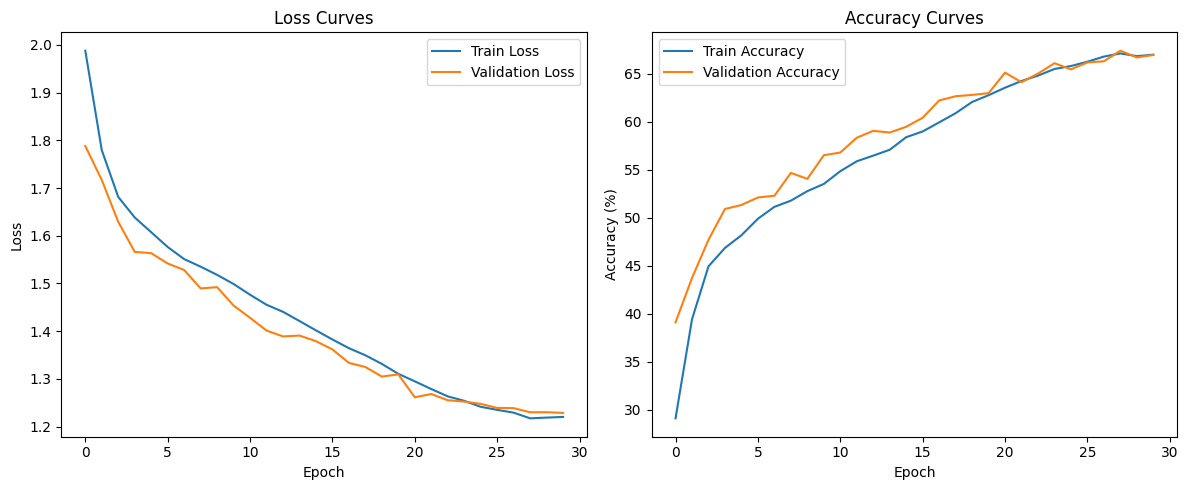

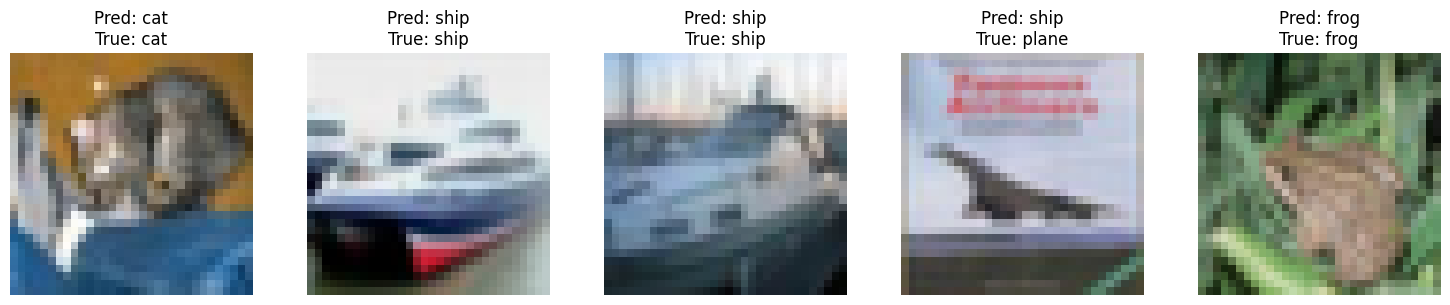

Running experiment with config: {'experiment_name': 'light_generalization', 'batch_size': 128, 'patch_size': 4, 'embedding_dim': 384, 'depth': 7, 'num_heads': 6, 'mlp_ratio': 2.0, 'dropout': 0.15, 'learning_rate': 0.0003, 'weight_decay': 0.0001, 'num_epochs': 30, 'patience': 3, 'augment': True, 'pos_embedding_type': '1d_learned', 'visualize_architecture': False}
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.60it/s, loss=1.78, acc=40.1]


Train Loss: 1.9543, Train Acc: 30.42%
Val Loss: 1.7779, Val Acc: 40.08%
Validation loss decreased (inf --> 1.777868). Saving model...

Epoch 2/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.03it/s, loss=1.68, acc=45]  


Train Loss: 1.7553, Train Acc: 40.98%
Val Loss: 1.6779, Val Acc: 45.02%
Validation loss decreased (1.777868 --> 1.677899). Saving model...

Epoch 3/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.60it/s, loss=1.57, acc=50.6]


Train Loss: 1.6552, Train Acc: 46.44%
Val Loss: 1.5653, Val Acc: 50.58%
Validation loss decreased (1.677899 --> 1.565252). Saving model...

Epoch 4/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.23it/s, loss=1.54, acc=52.2]


Train Loss: 1.6011, Train Acc: 48.77%
Val Loss: 1.5408, Val Acc: 52.18%
Validation loss decreased (1.565252 --> 1.540812). Saving model...

Epoch 5/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.18it/s, loss=1.52, acc=52.6]


Train Loss: 1.5576, Train Acc: 50.77%
Val Loss: 1.5220, Val Acc: 52.64%
Validation loss decreased (1.540812 --> 1.521964). Saving model...

Epoch 6/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.50it/s, loss=1.47, acc=55]  


Train Loss: 1.5296, Train Acc: 52.46%
Val Loss: 1.4681, Val Acc: 54.98%
Validation loss decreased (1.521964 --> 1.468099). Saving model...

Epoch 7/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.14it/s, loss=1.45, acc=56.3]


Train Loss: 1.4960, Train Acc: 53.89%
Val Loss: 1.4459, Val Acc: 56.32%
Validation loss decreased (1.468099 --> 1.445907). Saving model...

Epoch 8/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.99it/s, loss=1.42, acc=57.5]


Train Loss: 1.4683, Train Acc: 55.13%
Val Loss: 1.4170, Val Acc: 57.54%
Validation loss decreased (1.445907 --> 1.416970). Saving model...

Epoch 9/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.80it/s, loss=1.41, acc=58]  


Train Loss: 1.4388, Train Acc: 56.45%
Val Loss: 1.4055, Val Acc: 57.96%
Validation loss decreased (1.416970 --> 1.405538). Saving model...

Epoch 10/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.57it/s, loss=1.37, acc=60.9]


Train Loss: 1.4143, Train Acc: 57.49%
Val Loss: 1.3704, Val Acc: 60.94%
Validation loss decreased (1.405538 --> 1.370390). Saving model...

Epoch 11/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.13it/s, loss=1.34, acc=61]  


Train Loss: 1.3936, Train Acc: 58.84%
Val Loss: 1.3366, Val Acc: 60.96%
Validation loss decreased (1.370390 --> 1.336609). Saving model...

Epoch 12/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.62it/s, loss=1.33, acc=61.3]


Train Loss: 1.3661, Train Acc: 60.20%
Val Loss: 1.3255, Val Acc: 61.26%
Validation loss decreased (1.336609 --> 1.325513). Saving model...

Epoch 13/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.46it/s, loss=1.32, acc=62.4]


Train Loss: 1.3485, Train Acc: 60.95%
Val Loss: 1.3156, Val Acc: 62.36%
Validation loss decreased (1.325513 --> 1.315554). Saving model...

Epoch 14/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.24it/s, loss=1.28, acc=63.4]


Train Loss: 1.3215, Train Acc: 62.11%
Val Loss: 1.2820, Val Acc: 63.40%
Validation loss decreased (1.315554 --> 1.281969). Saving model...

Epoch 15/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.11it/s, loss=1.27, acc=64.7]


Train Loss: 1.3008, Train Acc: 63.12%
Val Loss: 1.2652, Val Acc: 64.66%
Validation loss decreased (1.281969 --> 1.265195). Saving model...

Epoch 16/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.74it/s, loss=1.25, acc=66.3]


Train Loss: 1.2730, Train Acc: 64.46%
Val Loss: 1.2458, Val Acc: 66.28%
Validation loss decreased (1.265195 --> 1.245786). Saving model...

Epoch 17/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.13it/s, loss=1.22, acc=66.9]


Train Loss: 1.2575, Train Acc: 65.39%
Val Loss: 1.2154, Val Acc: 66.94%
Validation loss decreased (1.245786 --> 1.215434). Saving model...

Epoch 18/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.95it/s, loss=1.2, acc=68.6] 


Train Loss: 1.2319, Train Acc: 66.40%
Val Loss: 1.1959, Val Acc: 68.60%
Validation loss decreased (1.215434 --> 1.195856). Saving model...

Epoch 19/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.21it/s, loss=1.2, acc=67.8] 


Train Loss: 1.2112, Train Acc: 67.43%
Val Loss: 1.2034, Val Acc: 67.80%
EarlyStopping counter: 1 out of 3

Epoch 20/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.49it/s, loss=1.18, acc=69.2]


Train Loss: 1.1936, Train Acc: 68.23%
Val Loss: 1.1783, Val Acc: 69.22%
Validation loss decreased (1.195856 --> 1.178268). Saving model...

Epoch 21/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.25it/s, loss=1.15, acc=70.6]


Train Loss: 1.1731, Train Acc: 69.36%
Val Loss: 1.1464, Val Acc: 70.58%
Validation loss decreased (1.178268 --> 1.146405). Saving model...

Epoch 22/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.10it/s, loss=1.15, acc=70.5]


Train Loss: 1.1545, Train Acc: 70.21%
Val Loss: 1.1469, Val Acc: 70.50%
EarlyStopping counter: 1 out of 3

Epoch 23/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.94it/s, loss=1.13, acc=71.3]


Train Loss: 1.1368, Train Acc: 70.84%
Val Loss: 1.1307, Val Acc: 71.26%
Validation loss decreased (1.146405 --> 1.130676). Saving model...

Epoch 24/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.98it/s, loss=1.11, acc=72.2]


Train Loss: 1.1240, Train Acc: 71.54%
Val Loss: 1.1080, Val Acc: 72.20%
Validation loss decreased (1.130676 --> 1.107966). Saving model...

Epoch 25/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.56it/s, loss=1.13, acc=72.1]


Train Loss: 1.1117, Train Acc: 72.14%
Val Loss: 1.1302, Val Acc: 72.10%
EarlyStopping counter: 1 out of 3

Epoch 26/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.11it/s, loss=1.1, acc=72.6] 


Train Loss: 1.1033, Train Acc: 72.57%
Val Loss: 1.0982, Val Acc: 72.56%
Validation loss decreased (1.107966 --> 1.098234). Saving model...

Epoch 27/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.95it/s, loss=1.1, acc=73.3] 


Train Loss: 1.0919, Train Acc: 73.24%
Val Loss: 1.0969, Val Acc: 73.28%
Validation loss decreased (1.098234 --> 1.096897). Saving model...

Epoch 28/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.36it/s, loss=1.08, acc=73.4]


Train Loss: 1.0894, Train Acc: 73.11%
Val Loss: 1.0829, Val Acc: 73.42%
Validation loss decreased (1.096897 --> 1.082901). Saving model...

Epoch 29/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.21it/s, loss=1.1, acc=72.8] 


Train Loss: 1.0846, Train Acc: 73.41%
Val Loss: 1.0994, Val Acc: 72.76%
EarlyStopping counter: 1 out of 3

Epoch 30/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.71it/s, loss=1.11, acc=73]  


Train Loss: 1.0817, Train Acc: 73.62%
Val Loss: 1.1055, Val Acc: 72.98%
EarlyStopping counter: 2 out of 3


Testing: 100%|██████████| 79/79 [00:03<00:00, 23.74it/s]


Test Accuracy: 74.24%


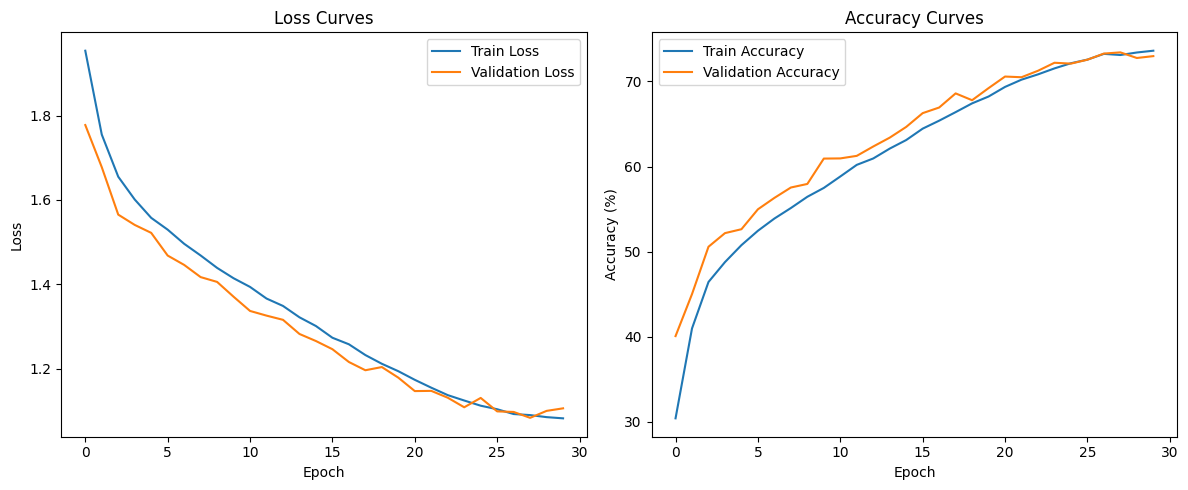

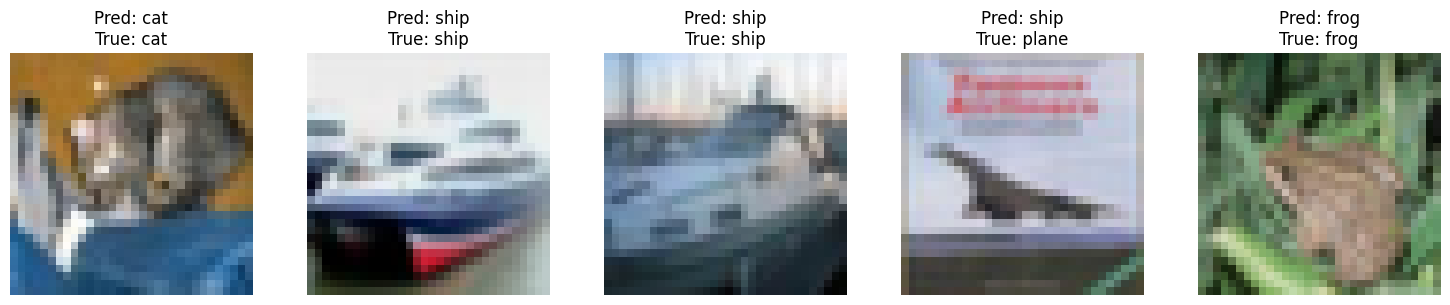


Hyperparameter Search Results:
Experiment: light_generalization, Test Accuracy: 74.24%
  patch_size: 4
  embedding_dim: 384
  depth: 7
  num_heads: 6
  mlp_ratio: 2.0
  dropout: 0.15
Experiment: high_capacity_reg, Test Accuracy: 68.86%
  patch_size: 4
  embedding_dim: 512
  depth: 8
  num_heads: 8
  mlp_ratio: 2.0
  dropout: 0.1


In [56]:
print("\n=== Running Hyperparameter Search ===")
hyper_results = hyperparameter_search()
# for the second and third configuration 


=== Running Hyperparameter Search ===
Running experiment with config: {'experiment_name': 'base', 'batch_size': 128, 'patch_size': 4, 'embedding_dim': 384, 'depth': 12, 'num_heads': 6, 'mlp_ratio': 4.0, 'dropout': 0.1, 'learning_rate': 0.0003, 'weight_decay': 0.0001, 'num_epochs': 30, 'patience': 3, 'augment': True, 'pos_embedding_type': '1d_learned', 'visualize_architecture': True}
Files already downloaded and verified
Files already downloaded and verified
To visualize the model architecture, install graphviz and torchviz.
pip install torchviz
For detailed model summary, we'll print the model structure instead:
DiffVisionTransformer(
  (patch_embedding): Conv2d(3, 384, kernel_size=(4, 4), stride=(4, 4))
  (pos_embedding): PositionalEmbedding()
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_blocks): ModuleList(
    (0-11): 12 x DiffTransformerEncoderBlock(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (diff_attn): DifferentialAttention(
        

Validation: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s, loss=1.82, acc=37.3]


Train Loss: 1.9891, Train Acc: 28.38%
Val Loss: 1.8220, Val Acc: 37.28%
Validation loss decreased (inf --> 1.822028). Saving model...

Epoch 2/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s, loss=1.71, acc=44.2]


Train Loss: 1.7750, Train Acc: 39.79%
Val Loss: 1.7059, Val Acc: 44.18%
Validation loss decreased (1.822028 --> 1.705908). Saving model...

Epoch 3/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s, loss=1.59, acc=50.4]


Train Loss: 1.6721, Train Acc: 44.82%
Val Loss: 1.5890, Val Acc: 50.36%
Validation loss decreased (1.705908 --> 1.588951). Saving model...

Epoch 4/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s, loss=1.62, acc=48.5]


Train Loss: 1.6112, Train Acc: 48.00%
Val Loss: 1.6167, Val Acc: 48.46%
EarlyStopping counter: 1 out of 3

Epoch 5/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 10.79it/s, loss=1.5, acc=54.4] 


Train Loss: 1.5679, Train Acc: 50.33%
Val Loss: 1.4969, Val Acc: 54.36%
Validation loss decreased (1.588951 --> 1.496873). Saving model...

Epoch 6/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s, loss=1.5, acc=53.5] 


Train Loss: 1.5315, Train Acc: 51.92%
Val Loss: 1.5000, Val Acc: 53.50%
EarlyStopping counter: 1 out of 3

Epoch 7/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s, loss=1.46, acc=55.8]


Train Loss: 1.5052, Train Acc: 53.44%
Val Loss: 1.4602, Val Acc: 55.84%
Validation loss decreased (1.496873 --> 1.460200). Saving model...

Epoch 8/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s, loss=1.44, acc=56.9]


Train Loss: 1.4695, Train Acc: 55.00%
Val Loss: 1.4405, Val Acc: 56.92%
Validation loss decreased (1.460200 --> 1.440522). Saving model...

Epoch 9/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s, loss=1.44, acc=56.8]


Train Loss: 1.4498, Train Acc: 56.07%
Val Loss: 1.4392, Val Acc: 56.78%
Validation loss decreased (1.440522 --> 1.439168). Saving model...

Epoch 10/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s, loss=1.4, acc=58.9] 


Train Loss: 1.4238, Train Acc: 57.17%
Val Loss: 1.3962, Val Acc: 58.88%
Validation loss decreased (1.439168 --> 1.396194). Saving model...

Epoch 11/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s, loss=1.36, acc=61.6]


Train Loss: 1.3975, Train Acc: 58.38%
Val Loss: 1.3606, Val Acc: 61.58%
Validation loss decreased (1.396194 --> 1.360568). Saving model...

Epoch 12/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s, loss=1.35, acc=62.5]


Train Loss: 1.3761, Train Acc: 59.59%
Val Loss: 1.3538, Val Acc: 62.54%
Validation loss decreased (1.360568 --> 1.353808). Saving model...

Epoch 13/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s, loss=1.34, acc=62.6]


Train Loss: 1.3491, Train Acc: 60.89%
Val Loss: 1.3355, Val Acc: 62.58%
Validation loss decreased (1.353808 --> 1.335508). Saving model...

Epoch 14/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s, loss=1.31, acc=62.9]


Train Loss: 1.3295, Train Acc: 61.66%
Val Loss: 1.3131, Val Acc: 62.94%
Validation loss decreased (1.335508 --> 1.313100). Saving model...

Epoch 15/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s, loss=1.3, acc=63.4] 


Train Loss: 1.3058, Train Acc: 62.95%
Val Loss: 1.2998, Val Acc: 63.44%
Validation loss decreased (1.313100 --> 1.299785). Saving model...

Epoch 16/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s, loss=1.26, acc=65.3]


Train Loss: 1.2812, Train Acc: 64.22%
Val Loss: 1.2590, Val Acc: 65.28%
Validation loss decreased (1.299785 --> 1.258964). Saving model...

Epoch 17/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.09it/s, loss=1.25, acc=66.1]


Train Loss: 1.2645, Train Acc: 64.73%
Val Loss: 1.2494, Val Acc: 66.06%
Validation loss decreased (1.258964 --> 1.249422). Saving model...

Epoch 18/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s, loss=1.24, acc=66.7]


Train Loss: 1.2361, Train Acc: 66.32%
Val Loss: 1.2356, Val Acc: 66.66%
Validation loss decreased (1.249422 --> 1.235610). Saving model...

Epoch 19/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s, loss=1.21, acc=68]  


Train Loss: 1.2094, Train Acc: 67.26%
Val Loss: 1.2077, Val Acc: 68.02%
Validation loss decreased (1.235610 --> 1.207716). Saving model...

Epoch 20/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s, loss=1.19, acc=69.6]


Train Loss: 1.1974, Train Acc: 68.05%
Val Loss: 1.1854, Val Acc: 69.62%
Validation loss decreased (1.207716 --> 1.185442). Saving model...

Epoch 21/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s, loss=1.18, acc=69.1]


Train Loss: 1.1725, Train Acc: 69.08%
Val Loss: 1.1791, Val Acc: 69.06%
Validation loss decreased (1.185442 --> 1.179140). Saving model...

Epoch 22/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s, loss=1.17, acc=70.1]


Train Loss: 1.1575, Train Acc: 69.82%
Val Loss: 1.1696, Val Acc: 70.14%
Validation loss decreased (1.179140 --> 1.169572). Saving model...

Epoch 23/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 10.95it/s, loss=1.15, acc=71.2]


Train Loss: 1.1354, Train Acc: 70.95%
Val Loss: 1.1525, Val Acc: 71.20%
Validation loss decreased (1.169572 --> 1.152483). Saving model...

Epoch 24/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s, loss=1.14, acc=72]  


Train Loss: 1.1170, Train Acc: 71.80%
Val Loss: 1.1448, Val Acc: 71.96%
Validation loss decreased (1.152483 --> 1.144812). Saving model...

Epoch 25/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s, loss=1.12, acc=72.1]


Train Loss: 1.1080, Train Acc: 72.10%
Val Loss: 1.1228, Val Acc: 72.06%
Validation loss decreased (1.144812 --> 1.122835). Saving model...

Epoch 26/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s, loss=1.12, acc=72.2]


Train Loss: 1.0955, Train Acc: 72.80%
Val Loss: 1.1247, Val Acc: 72.16%
EarlyStopping counter: 1 out of 3

Epoch 27/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s, loss=1.1, acc=72.8] 


Train Loss: 1.0838, Train Acc: 73.26%
Val Loss: 1.1022, Val Acc: 72.76%
Validation loss decreased (1.122835 --> 1.102198). Saving model...

Epoch 28/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.11it/s, loss=1.12, acc=72]  


Train Loss: 1.0820, Train Acc: 73.26%
Val Loss: 1.1199, Val Acc: 72.04%
EarlyStopping counter: 1 out of 3

Epoch 29/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s, loss=1.1, acc=73.1] 


Train Loss: 1.0781, Train Acc: 73.34%
Val Loss: 1.1007, Val Acc: 73.10%
Validation loss decreased (1.102198 --> 1.100662). Saving model...

Epoch 30/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s, loss=1.1, acc=73.1] 
/tmp/ipykernel_31/2527600923.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load

Train Loss: 1.0705, Train Acc: 73.97%
Val Loss: 1.1013, Val Acc: 73.12%
EarlyStopping counter: 1 out of 3


Testing: 100%|██████████| 79/79 [00:06<00:00, 11.46it/s]


Test Accuracy: 73.78%


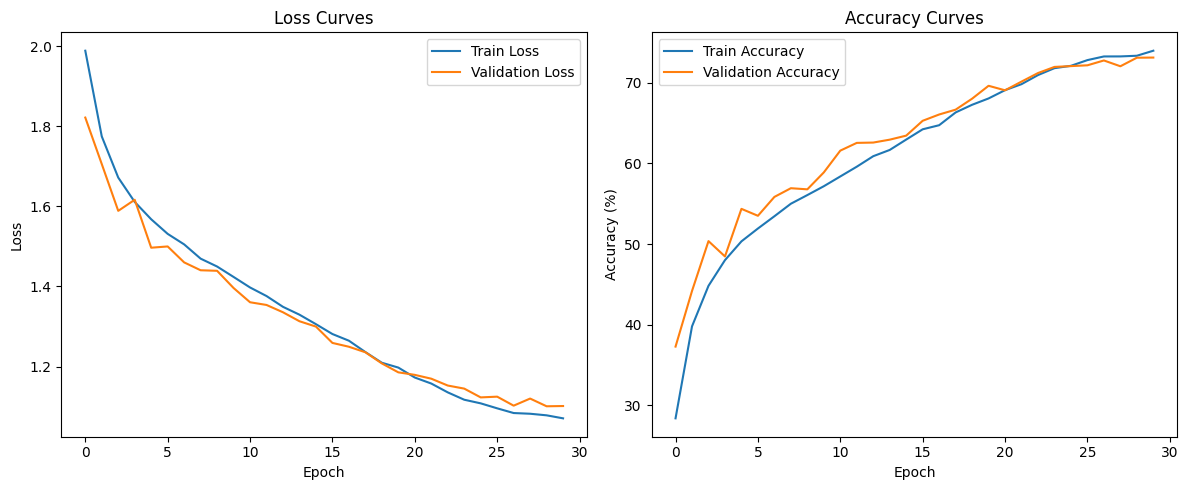

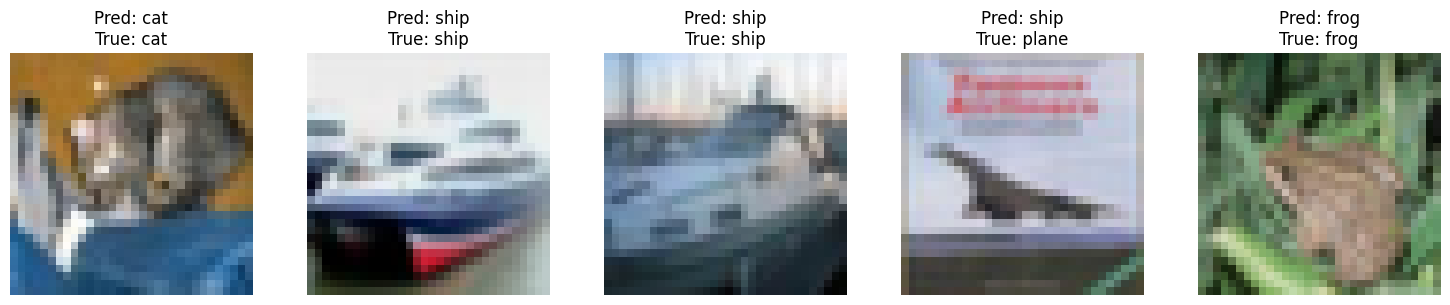

Running experiment with config: {'experiment_name': 'wide_mlp_high_dropout', 'batch_size': 128, 'patch_size': 4, 'embedding_dim': 384, 'depth': 9, 'num_heads': 6, 'mlp_ratio': 4.0, 'dropout': 0.2, 'learning_rate': 0.0003, 'weight_decay': 0.0001, 'num_epochs': 30, 'patience': 3, 'augment': True, 'pos_embedding_type': '1d_learned', 'visualize_architecture': False}
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.95it/s, loss=1.84, acc=35.5]


Train Loss: 2.0277, Train Acc: 26.54%
Val Loss: 1.8399, Val Acc: 35.46%
Validation loss decreased (inf --> 1.839914). Saving model...

Epoch 2/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.10it/s, loss=1.71, acc=43.6]


Train Loss: 1.8317, Train Acc: 36.67%
Val Loss: 1.7084, Val Acc: 43.64%
Validation loss decreased (1.839914 --> 1.708448). Saving model...

Epoch 3/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.17it/s, loss=1.62, acc=47.4]


Train Loss: 1.7297, Train Acc: 42.29%
Val Loss: 1.6240, Val Acc: 47.40%
Validation loss decreased (1.708448 --> 1.624046). Saving model...

Epoch 4/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.22it/s, loss=1.57, acc=49.5]


Train Loss: 1.6597, Train Acc: 45.83%
Val Loss: 1.5679, Val Acc: 49.48%
Validation loss decreased (1.624046 --> 1.567942). Saving model...

Epoch 5/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.13it/s, loss=1.56, acc=49.8]


Train Loss: 1.6212, Train Acc: 47.40%
Val Loss: 1.5629, Val Acc: 49.80%
Validation loss decreased (1.567942 --> 1.562876). Saving model...

Epoch 6/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.64it/s, loss=1.53, acc=52.8]


Train Loss: 1.5787, Train Acc: 49.50%
Val Loss: 1.5344, Val Acc: 52.78%
Validation loss decreased (1.562876 --> 1.534362). Saving model...

Epoch 7/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.28it/s, loss=1.5, acc=54.2] 


Train Loss: 1.5532, Train Acc: 50.62%
Val Loss: 1.5020, Val Acc: 54.20%
Validation loss decreased (1.534362 --> 1.502012). Saving model...

Epoch 8/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.26it/s, loss=1.48, acc=53.9]


Train Loss: 1.5262, Train Acc: 52.14%
Val Loss: 1.4753, Val Acc: 53.88%
Validation loss decreased (1.502012 --> 1.475294). Saving model...

Epoch 9/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.27it/s, loss=1.46, acc=56]  


Train Loss: 1.4979, Train Acc: 53.76%
Val Loss: 1.4587, Val Acc: 55.96%
Validation loss decreased (1.475294 --> 1.458687). Saving model...

Epoch 10/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.19it/s, loss=1.43, acc=55.9]


Train Loss: 1.4769, Train Acc: 54.62%
Val Loss: 1.4334, Val Acc: 55.88%
Validation loss decreased (1.458687 --> 1.433402). Saving model...

Epoch 11/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.12it/s, loss=1.39, acc=58.5]


Train Loss: 1.4571, Train Acc: 55.44%
Val Loss: 1.3890, Val Acc: 58.52%
Validation loss decreased (1.433402 --> 1.388970). Saving model...

Epoch 12/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.10it/s, loss=1.38, acc=59.8]


Train Loss: 1.4330, Train Acc: 56.66%
Val Loss: 1.3764, Val Acc: 59.82%
Validation loss decreased (1.388970 --> 1.376397). Saving model...

Epoch 13/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.17it/s, loss=1.35, acc=61]  


Train Loss: 1.4103, Train Acc: 57.50%
Val Loss: 1.3476, Val Acc: 61.02%
Validation loss decreased (1.376397 --> 1.347631). Saving model...

Epoch 14/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.29it/s, loss=1.36, acc=60.8]


Train Loss: 1.3862, Train Acc: 58.90%
Val Loss: 1.3564, Val Acc: 60.82%
EarlyStopping counter: 1 out of 3

Epoch 15/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.15it/s, loss=1.31, acc=63.5]


Train Loss: 1.3653, Train Acc: 60.16%
Val Loss: 1.3145, Val Acc: 63.50%
Validation loss decreased (1.347631 --> 1.314481). Saving model...

Epoch 16/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.12it/s, loss=1.3, acc=63.2] 


Train Loss: 1.3419, Train Acc: 61.62%
Val Loss: 1.2968, Val Acc: 63.24%
Validation loss decreased (1.314481 --> 1.296752). Saving model...

Epoch 17/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.19it/s, loss=1.27, acc=64.4]


Train Loss: 1.3250, Train Acc: 61.93%
Val Loss: 1.2660, Val Acc: 64.40%
Validation loss decreased (1.296752 --> 1.266005). Saving model...

Epoch 18/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.26it/s, loss=1.26, acc=64.9]


Train Loss: 1.3012, Train Acc: 63.12%
Val Loss: 1.2619, Val Acc: 64.92%
Validation loss decreased (1.266005 --> 1.261944). Saving model...

Epoch 19/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.18it/s, loss=1.23, acc=67.1]


Train Loss: 1.2821, Train Acc: 63.88%
Val Loss: 1.2278, Val Acc: 67.12%
Validation loss decreased (1.261944 --> 1.227810). Saving model...

Epoch 20/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.06it/s, loss=1.22, acc=67.6]


Train Loss: 1.2676, Train Acc: 64.57%
Val Loss: 1.2199, Val Acc: 67.56%
Validation loss decreased (1.227810 --> 1.219915). Saving model...

Epoch 21/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.23it/s, loss=1.21, acc=67.8]


Train Loss: 1.2444, Train Acc: 65.93%
Val Loss: 1.2110, Val Acc: 67.80%
Validation loss decreased (1.219915 --> 1.211005). Saving model...

Epoch 22/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.17it/s, loss=1.2, acc=68.8] 


Train Loss: 1.2283, Train Acc: 66.57%
Val Loss: 1.2020, Val Acc: 68.76%
Validation loss decreased (1.211005 --> 1.202025). Saving model...

Epoch 23/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.14it/s, loss=1.18, acc=68.5]


Train Loss: 1.2129, Train Acc: 67.22%
Val Loss: 1.1846, Val Acc: 68.48%
Validation loss decreased (1.202025 --> 1.184572). Saving model...

Epoch 24/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.13it/s, loss=1.17, acc=69.6]


Train Loss: 1.1942, Train Acc: 68.25%
Val Loss: 1.1661, Val Acc: 69.60%
Validation loss decreased (1.184572 --> 1.166095). Saving model...

Epoch 25/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.06it/s, loss=1.17, acc=69]  


Train Loss: 1.1905, Train Acc: 68.50%
Val Loss: 1.1736, Val Acc: 69.04%
EarlyStopping counter: 1 out of 3

Epoch 26/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.13it/s, loss=1.15, acc=70.7]


Train Loss: 1.1780, Train Acc: 68.89%
Val Loss: 1.1547, Val Acc: 70.70%
Validation loss decreased (1.166095 --> 1.154703). Saving model...

Epoch 27/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.13it/s, loss=1.15, acc=70.9]


Train Loss: 1.1709, Train Acc: 69.17%
Val Loss: 1.1520, Val Acc: 70.90%
Validation loss decreased (1.154703 --> 1.152037). Saving model...

Epoch 28/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.17it/s, loss=1.14, acc=71.3]


Train Loss: 1.1689, Train Acc: 69.18%
Val Loss: 1.1395, Val Acc: 71.30%
Validation loss decreased (1.152037 --> 1.139491). Saving model...

Epoch 29/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.18it/s, loss=1.14, acc=71.2]


Train Loss: 1.1574, Train Acc: 69.95%
Val Loss: 1.1361, Val Acc: 71.16%
Validation loss decreased (1.139491 --> 1.136110). Saving model...

Epoch 30/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.09it/s, loss=1.14, acc=70.5]


Train Loss: 1.1618, Train Acc: 69.74%
Val Loss: 1.1409, Val Acc: 70.46%
EarlyStopping counter: 1 out of 3


Testing: 100%|██████████| 79/79 [00:05<00:00, 14.98it/s]


Test Accuracy: 72.19%


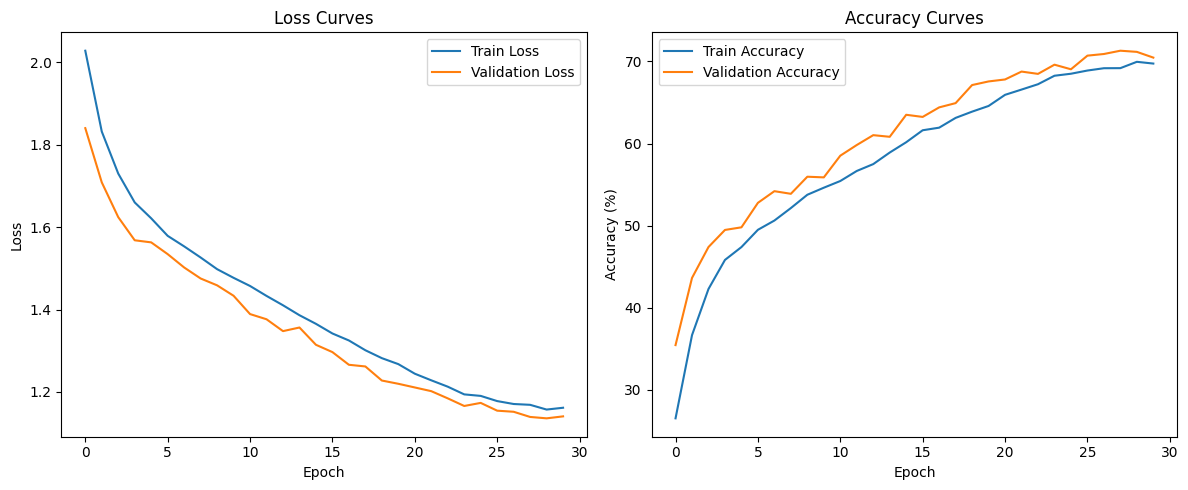

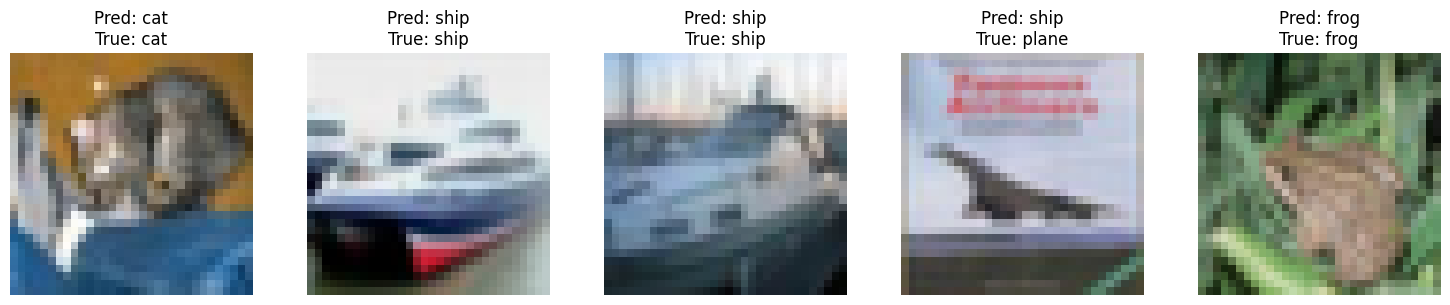

Running experiment with config: {'experiment_name': 'light_generalization', 'batch_size': 128, 'patch_size': 4, 'embedding_dim': 384, 'depth': 7, 'num_heads': 6, 'mlp_ratio': 2.0, 'dropout': 0.15, 'learning_rate': 0.0003, 'weight_decay': 0.0001, 'num_epochs': 30, 'patience': 3, 'augment': True, 'pos_embedding_type': '1d_learned', 'visualize_architecture': False}
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/30


Training:  11%|█         | 37/352 [00:04<00:38,  8.27it/s, loss=2.23, acc=19.7]

In [ ]:
print("\n=== Running Hyperparameter Search ===")
hyper_results = hyperparameter_search()
# for the second and third configuration 


=== Running Positional Embedding Experiment ===
Running experiment with config: {'experiment_name': 'pos_none', 'batch_size': 128, 'patch_size': 4, 'embedding_dim': 512, 'depth': 6, 'num_heads': 4, 'mlp_ratio': 2.0, 'dropout': 0.1, 'learning_rate': 0.0003, 'weight_decay': 0.0001, 'num_epochs': 30, 'patience': 3, 'augment': True, 'visualize_architecture': False, 'qkv_bias': True, 'use_faster_attention': True, 'pos_embedding_type': 'none'}
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.02it/s, loss=1.84, acc=35.6]


Train Loss: 1.9998, Train Acc: 28.42%
Val Loss: 1.8369, Val Acc: 35.56%
Validation loss decreased (inf --> 1.836923). Saving model...

Epoch 2/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.84it/s, loss=1.78, acc=40.2]


Train Loss: 1.8266, Train Acc: 37.28%
Val Loss: 1.7811, Val Acc: 40.24%
Validation loss decreased (1.836923 --> 1.781103). Saving model...

Epoch 3/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.92it/s, loss=1.67, acc=45.6]


Train Loss: 1.7685, Train Acc: 40.51%
Val Loss: 1.6686, Val Acc: 45.62%
Validation loss decreased (1.781103 --> 1.668615). Saving model...

Epoch 4/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.09it/s, loss=1.66, acc=44.4]


Train Loss: 1.7334, Train Acc: 42.03%
Val Loss: 1.6644, Val Acc: 44.40%
Validation loss decreased (1.668615 --> 1.664372). Saving model...

Epoch 5/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.80it/s, loss=1.68, acc=44.2]


Train Loss: 1.7118, Train Acc: 43.44%
Val Loss: 1.6763, Val Acc: 44.22%
EarlyStopping counter: 1 out of 3

Epoch 6/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.63it/s, loss=1.65, acc=46.4]


Train Loss: 1.7020, Train Acc: 43.70%
Val Loss: 1.6541, Val Acc: 46.40%
Validation loss decreased (1.664372 --> 1.654121). Saving model...

Epoch 7/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.04it/s, loss=1.63, acc=47.3]


Train Loss: 1.6814, Train Acc: 44.92%
Val Loss: 1.6262, Val Acc: 47.34%
Validation loss decreased (1.654121 --> 1.626200). Saving model...

Epoch 8/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.79it/s, loss=1.61, acc=48.4]


Train Loss: 1.6676, Train Acc: 45.72%
Val Loss: 1.6095, Val Acc: 48.40%
Validation loss decreased (1.626200 --> 1.609510). Saving model...

Epoch 9/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.11it/s, loss=1.6, acc=47.7] 


Train Loss: 1.6479, Train Acc: 46.42%
Val Loss: 1.5982, Val Acc: 47.72%
Validation loss decreased (1.609510 --> 1.598220). Saving model...

Epoch 10/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.72it/s, loss=1.57, acc=50.5]


Train Loss: 1.6262, Train Acc: 47.70%
Val Loss: 1.5675, Val Acc: 50.46%
Validation loss decreased (1.598220 --> 1.567543). Saving model...

Epoch 11/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.34it/s, loss=1.56, acc=50.6]


Train Loss: 1.6122, Train Acc: 48.35%
Val Loss: 1.5598, Val Acc: 50.60%
Validation loss decreased (1.567543 --> 1.559814). Saving model...

Epoch 12/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.02it/s, loss=1.59, acc=48.3]


Train Loss: 1.5999, Train Acc: 48.65%
Val Loss: 1.5913, Val Acc: 48.32%
EarlyStopping counter: 1 out of 3

Epoch 13/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=1.54, acc=51.1]


Train Loss: 1.5794, Train Acc: 49.72%
Val Loss: 1.5392, Val Acc: 51.10%
Validation loss decreased (1.559814 --> 1.539188). Saving model...

Epoch 14/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.59it/s, loss=1.52, acc=52.9]


Train Loss: 1.5698, Train Acc: 50.52%
Val Loss: 1.5162, Val Acc: 52.88%
Validation loss decreased (1.539188 --> 1.516210). Saving model...

Epoch 15/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.13it/s, loss=1.49, acc=54.4]


Train Loss: 1.5520, Train Acc: 50.94%
Val Loss: 1.4929, Val Acc: 54.40%
Validation loss decreased (1.516210 --> 1.492903). Saving model...

Epoch 16/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.36it/s, loss=1.49, acc=54.9]


Train Loss: 1.5323, Train Acc: 52.18%
Val Loss: 1.4879, Val Acc: 54.88%
Validation loss decreased (1.492903 --> 1.487889). Saving model...

Epoch 17/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.73it/s, loss=1.47, acc=55.4]


Train Loss: 1.5146, Train Acc: 53.10%
Val Loss: 1.4663, Val Acc: 55.44%
Validation loss decreased (1.487889 --> 1.466336). Saving model...

Epoch 18/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.35it/s, loss=1.46, acc=56.3]


Train Loss: 1.4971, Train Acc: 53.87%
Val Loss: 1.4573, Val Acc: 56.30%
Validation loss decreased (1.466336 --> 1.457340). Saving model...

Epoch 19/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.79it/s, loss=1.46, acc=55.8]


Train Loss: 1.4832, Train Acc: 54.30%
Val Loss: 1.4597, Val Acc: 55.82%
EarlyStopping counter: 1 out of 3

Epoch 20/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.47it/s, loss=1.44, acc=56]  


Train Loss: 1.4690, Train Acc: 55.36%
Val Loss: 1.4389, Val Acc: 56.00%
Validation loss decreased (1.457340 --> 1.438869). Saving model...

Epoch 21/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.84it/s, loss=1.42, acc=57.1]


Train Loss: 1.4569, Train Acc: 55.62%
Val Loss: 1.4215, Val Acc: 57.12%
Validation loss decreased (1.438869 --> 1.421506). Saving model...

Epoch 22/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.51it/s, loss=1.41, acc=58.5]


Train Loss: 1.4324, Train Acc: 56.87%
Val Loss: 1.4101, Val Acc: 58.46%
Validation loss decreased (1.421506 --> 1.410111). Saving model...

Epoch 23/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.66it/s, loss=1.4, acc=58.1] 


Train Loss: 1.4271, Train Acc: 57.10%
Val Loss: 1.4005, Val Acc: 58.10%
Validation loss decreased (1.410111 --> 1.400451). Saving model...

Epoch 24/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.87it/s, loss=1.39, acc=58.5]


Train Loss: 1.4160, Train Acc: 57.70%
Val Loss: 1.3921, Val Acc: 58.50%
Validation loss decreased (1.400451 --> 1.392145). Saving model...

Epoch 25/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.68it/s, loss=1.39, acc=58.5]


Train Loss: 1.4030, Train Acc: 58.47%
Val Loss: 1.3876, Val Acc: 58.52%
Validation loss decreased (1.392145 --> 1.387574). Saving model...

Epoch 26/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.07it/s, loss=1.37, acc=59.5]


Train Loss: 1.3974, Train Acc: 58.64%
Val Loss: 1.3734, Val Acc: 59.52%
Validation loss decreased (1.387574 --> 1.373446). Saving model...

Epoch 27/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.74it/s, loss=1.36, acc=60.8]


Train Loss: 1.3932, Train Acc: 58.87%
Val Loss: 1.3623, Val Acc: 60.82%
Validation loss decreased (1.373446 --> 1.362313). Saving model...

Epoch 28/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.38it/s, loss=1.36, acc=61.4]


Train Loss: 1.3862, Train Acc: 59.19%
Val Loss: 1.3642, Val Acc: 61.40%
EarlyStopping counter: 1 out of 3

Epoch 29/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.72it/s, loss=1.37, acc=60.2]


Train Loss: 1.3854, Train Acc: 59.11%
Val Loss: 1.3696, Val Acc: 60.24%
EarlyStopping counter: 2 out of 3

Epoch 30/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.27it/s, loss=1.37, acc=60.3]
/tmp/ipykernel_31/2527600923.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load

Train Loss: 1.3833, Train Acc: 59.42%
Val Loss: 1.3716, Val Acc: 60.32%
EarlyStopping counter: 3 out of 3
Early stopping triggered


Testing: 100%|██████████| 79/79 [00:04<00:00, 19.20it/s]


Test Accuracy: 59.77%


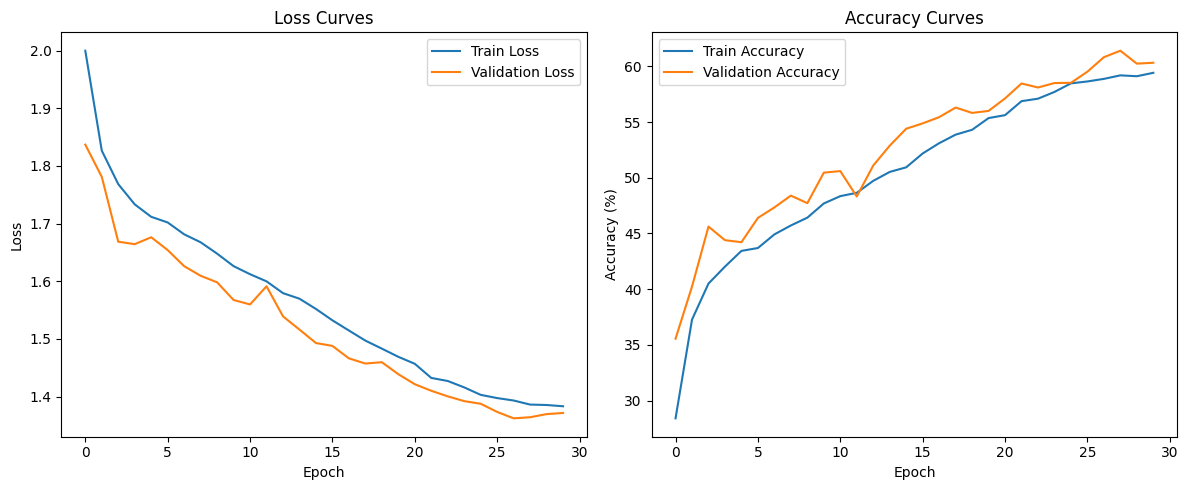

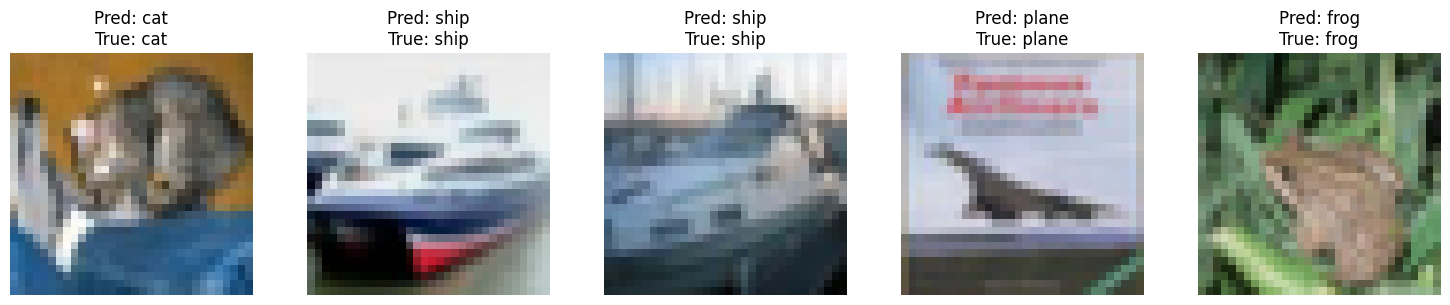

Running experiment with config: {'experiment_name': 'pos_1d_learned', 'batch_size': 128, 'patch_size': 4, 'embedding_dim': 512, 'depth': 6, 'num_heads': 4, 'mlp_ratio': 2.0, 'dropout': 0.1, 'learning_rate': 0.0003, 'weight_decay': 0.0001, 'num_epochs': 30, 'patience': 3, 'augment': True, 'visualize_architecture': False, 'qkv_bias': True, 'use_faster_attention': True, 'pos_embedding_type': '1d_learned'}
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.48it/s, loss=1.83, acc=36.3]


Train Loss: 1.9948, Train Acc: 28.57%
Val Loss: 1.8322, Val Acc: 36.28%
Validation loss decreased (inf --> 1.832150). Saving model...

Epoch 2/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.07it/s, loss=1.7, acc=43.7] 


Train Loss: 1.8048, Train Acc: 38.89%
Val Loss: 1.7050, Val Acc: 43.66%
Validation loss decreased (1.832150 --> 1.704986). Saving model...

Epoch 3/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.44it/s, loss=1.7, acc=44.1] 


Train Loss: 1.7297, Train Acc: 42.52%
Val Loss: 1.7045, Val Acc: 44.14%
Validation loss decreased (1.704986 --> 1.704481). Saving model...

Epoch 4/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.71it/s, loss=1.66, acc=46.8]


Train Loss: 1.6958, Train Acc: 43.82%
Val Loss: 1.6554, Val Acc: 46.80%
Validation loss decreased (1.704481 --> 1.655421). Saving model...

Epoch 5/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.90it/s, loss=1.66, acc=45.7]


Train Loss: 1.6805, Train Acc: 44.82%
Val Loss: 1.6602, Val Acc: 45.68%
EarlyStopping counter: 1 out of 3

Epoch 6/30


Training:  25%|██▌       | 88/352 [00:13<00:39,  6.65it/s, loss=1.68, acc=45]  

In [ ]:
# Run positional embedding experiment
print("\n=== Running Positional Embedding Experiment ===")
pos_results = positional_embedding_experiment()


=== Running Positional Embedding Experiment ===
Running experiment with config: {'experiment_name': 'pos_1d_learned', 'batch_size': 128, 'patch_size': 4, 'embedding_dim': 512, 'depth': 6, 'num_heads': 4, 'mlp_ratio': 2.0, 'dropout': 0.1, 'learning_rate': 0.0003, 'weight_decay': 0.0001, 'num_epochs': 30, 'patience': 3, 'augment': True, 'visualize_architecture': False, 'qkv_bias': True, 'use_faster_attention': True, 'pos_embedding_type': '1d_learned'}


100%|██████████| 170M/170M [00:02<00:00, 76.1MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Epoch 1/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.78it/s, loss=1.84, acc=37.1]


Train Loss: 1.9750, Train Acc: 29.81%
Val Loss: 1.8394, Val Acc: 37.10%
Validation loss decreased (inf --> 1.839415). Saving model...

Epoch 2/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s, loss=1.71, acc=43]  


Train Loss: 1.8010, Train Acc: 38.74%
Val Loss: 1.7146, Val Acc: 42.96%
Validation loss decreased (1.839415 --> 1.714649). Saving model...

Epoch 3/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.02it/s, loss=1.68, acc=44]  


Train Loss: 1.7261, Train Acc: 42.96%
Val Loss: 1.6819, Val Acc: 44.04%
Validation loss decreased (1.714649 --> 1.681896). Saving model...

Epoch 4/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.56it/s, loss=1.63, acc=47.1]


Train Loss: 1.6976, Train Acc: 43.78%
Val Loss: 1.6339, Val Acc: 47.10%
Validation loss decreased (1.681896 --> 1.633882). Saving model...

Epoch 5/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.66it/s, loss=1.66, acc=45.9]


Train Loss: 1.6657, Train Acc: 45.34%
Val Loss: 1.6608, Val Acc: 45.86%
EarlyStopping counter: 1 out of 3

Epoch 6/30


Validation: 100%|██████████| 40/40 [00:03<00:00, 13.15it/s, loss=1.64, acc=46]  


Train Loss: 1.6552, Train Acc: 45.81%
Val Loss: 1.6400, Val Acc: 45.96%
EarlyStopping counter: 2 out of 3

Epoch 7/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.75it/s, loss=1.59, acc=49]  


Train Loss: 1.6327, Train Acc: 47.19%
Val Loss: 1.5867, Val Acc: 49.02%
Validation loss decreased (1.633882 --> 1.586740). Saving model...

Epoch 8/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.81it/s, loss=1.56, acc=50.7]


Train Loss: 1.6113, Train Acc: 48.07%
Val Loss: 1.5561, Val Acc: 50.72%
Validation loss decreased (1.586740 --> 1.556064). Saving model...

Epoch 9/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.91it/s, loss=1.57, acc=49.8]


Train Loss: 1.5976, Train Acc: 48.77%
Val Loss: 1.5726, Val Acc: 49.76%
EarlyStopping counter: 1 out of 3

Epoch 10/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s, loss=1.53, acc=52]  


Train Loss: 1.5868, Train Acc: 49.17%
Val Loss: 1.5256, Val Acc: 51.96%
Validation loss decreased (1.556064 --> 1.525608). Saving model...

Epoch 11/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.26it/s, loss=1.51, acc=52.6]


Train Loss: 1.5592, Train Acc: 50.52%
Val Loss: 1.5149, Val Acc: 52.60%
Validation loss decreased (1.525608 --> 1.514874). Saving model...

Epoch 12/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.02it/s, loss=1.5, acc=53.1] 


Train Loss: 1.5399, Train Acc: 51.56%
Val Loss: 1.5012, Val Acc: 53.06%
Validation loss decreased (1.514874 --> 1.501190). Saving model...

Epoch 13/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.32it/s, loss=1.46, acc=55.6]


Train Loss: 1.5213, Train Acc: 52.46%
Val Loss: 1.4613, Val Acc: 55.60%
Validation loss decreased (1.501190 --> 1.461300). Saving model...

Epoch 14/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.74it/s, loss=1.46, acc=55.1]


Train Loss: 1.5022, Train Acc: 53.43%
Val Loss: 1.4580, Val Acc: 55.12%
Validation loss decreased (1.461300 --> 1.458043). Saving model...

Epoch 15/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.73it/s, loss=1.45, acc=55.8]


Train Loss: 1.4915, Train Acc: 54.14%
Val Loss: 1.4477, Val Acc: 55.76%
Validation loss decreased (1.458043 --> 1.447709). Saving model...

Epoch 16/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.42it/s, loss=1.43, acc=55.6]


Train Loss: 1.4684, Train Acc: 55.06%
Val Loss: 1.4328, Val Acc: 55.64%
Validation loss decreased (1.447709 --> 1.432822). Saving model...

Epoch 17/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.60it/s, loss=1.4, acc=57.7] 


Train Loss: 1.4519, Train Acc: 55.86%
Val Loss: 1.4032, Val Acc: 57.72%
Validation loss decreased (1.432822 --> 1.403156). Saving model...

Epoch 18/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.50it/s, loss=1.39, acc=59]  


Train Loss: 1.4301, Train Acc: 56.94%
Val Loss: 1.3859, Val Acc: 59.00%
Validation loss decreased (1.403156 --> 1.385857). Saving model...

Epoch 19/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.22it/s, loss=1.37, acc=59.6]


Train Loss: 1.4114, Train Acc: 58.08%
Val Loss: 1.3699, Val Acc: 59.64%
Validation loss decreased (1.385857 --> 1.369897). Saving model...

Epoch 20/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.42it/s, loss=1.35, acc=60.9]


Train Loss: 1.3935, Train Acc: 58.70%
Val Loss: 1.3509, Val Acc: 60.86%
Validation loss decreased (1.369897 --> 1.350912). Saving model...

Epoch 21/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.77it/s, loss=1.35, acc=60.3]


Train Loss: 1.3761, Train Acc: 59.53%
Val Loss: 1.3497, Val Acc: 60.26%
Validation loss decreased (1.350912 --> 1.349728). Saving model...

Epoch 22/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.52it/s, loss=1.32, acc=62.2]


Train Loss: 1.3644, Train Acc: 60.25%
Val Loss: 1.3225, Val Acc: 62.20%
Validation loss decreased (1.349728 --> 1.322518). Saving model...

Epoch 23/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.65it/s, loss=1.31, acc=62.4]


Train Loss: 1.3478, Train Acc: 60.89%
Val Loss: 1.3127, Val Acc: 62.44%
Validation loss decreased (1.322518 --> 1.312714). Saving model...

Epoch 24/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.88it/s, loss=1.31, acc=62.4]


Train Loss: 1.3362, Train Acc: 61.50%
Val Loss: 1.3103, Val Acc: 62.36%
Validation loss decreased (1.312714 --> 1.310275). Saving model...

Epoch 25/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.92it/s, loss=1.3, acc=63]   


Train Loss: 1.3259, Train Acc: 61.98%
Val Loss: 1.3049, Val Acc: 62.96%
Validation loss decreased (1.310275 --> 1.304947). Saving model...

Epoch 26/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.48it/s, loss=1.29, acc=63.2]


Train Loss: 1.3145, Train Acc: 62.60%
Val Loss: 1.2880, Val Acc: 63.24%
Validation loss decreased (1.304947 --> 1.287984). Saving model...

Epoch 27/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.59it/s, loss=1.29, acc=63.6]


Train Loss: 1.3097, Train Acc: 62.72%
Val Loss: 1.2929, Val Acc: 63.60%
EarlyStopping counter: 1 out of 3

Epoch 28/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.02it/s, loss=1.3, acc=63.4] 


Train Loss: 1.3057, Train Acc: 62.62%
Val Loss: 1.2985, Val Acc: 63.40%
EarlyStopping counter: 2 out of 3

Epoch 29/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.33it/s, loss=1.28, acc=63.5]


Train Loss: 1.2981, Train Acc: 63.26%
Val Loss: 1.2766, Val Acc: 63.46%
Validation loss decreased (1.287984 --> 1.276616). Saving model...

Epoch 30/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.45it/s, loss=1.29, acc=62.7]
/tmp/ipykernel_31/2527600923.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load

Train Loss: 1.2996, Train Acc: 63.22%
Val Loss: 1.2930, Val Acc: 62.74%
EarlyStopping counter: 1 out of 3


Testing: 100%|██████████| 79/79 [00:04<00:00, 18.71it/s]


Test Accuracy: 65.45%


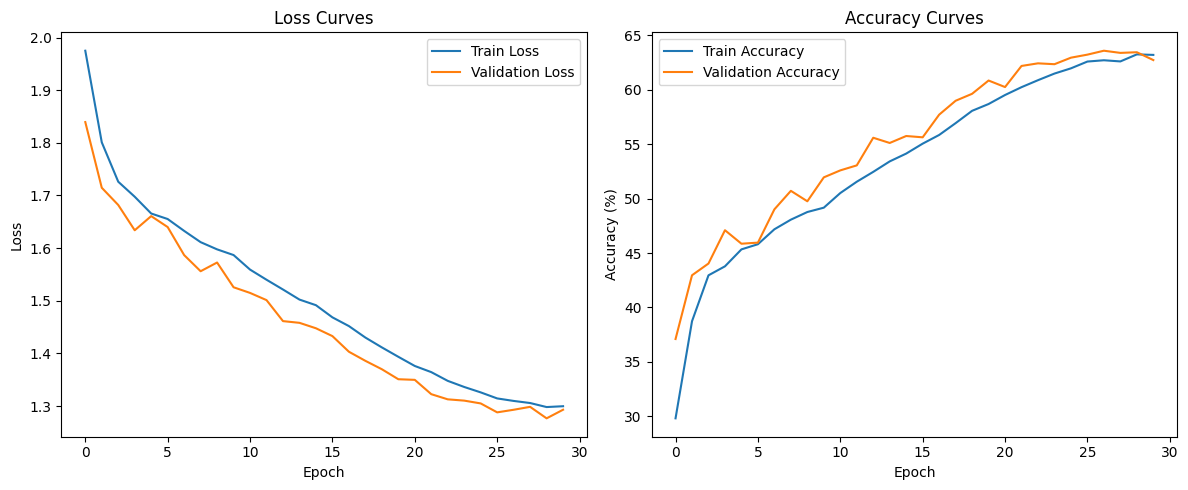

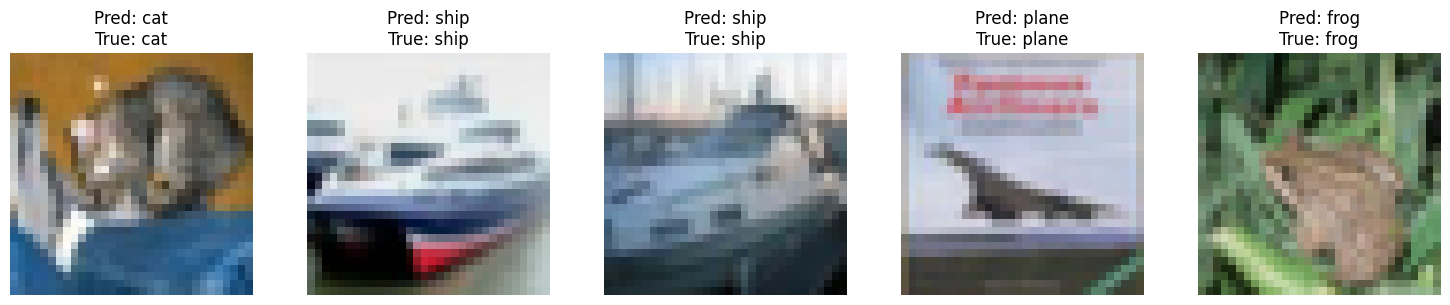

Running experiment with config: {'experiment_name': 'pos_2d_learned', 'batch_size': 128, 'patch_size': 4, 'embedding_dim': 512, 'depth': 6, 'num_heads': 4, 'mlp_ratio': 2.0, 'dropout': 0.1, 'learning_rate': 0.0003, 'weight_decay': 0.0001, 'num_epochs': 30, 'patience': 3, 'augment': True, 'visualize_architecture': False, 'qkv_bias': True, 'use_faster_attention': True, 'pos_embedding_type': '2d_learned'}
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.59it/s, loss=1.92, acc=33.3]


Train Loss: 2.0036, Train Acc: 28.49%
Val Loss: 1.9157, Val Acc: 33.34%
Validation loss decreased (inf --> 1.915686). Saving model...

Epoch 2/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.39it/s, loss=1.78, acc=41]  


Train Loss: 1.8257, Train Acc: 37.34%
Val Loss: 1.7788, Val Acc: 41.00%
Validation loss decreased (1.915686 --> 1.778846). Saving model...

Epoch 3/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.41it/s, loss=1.68, acc=46.5]


Train Loss: 1.7458, Train Acc: 41.65%
Val Loss: 1.6841, Val Acc: 46.50%
Validation loss decreased (1.778846 --> 1.684099). Saving model...

Epoch 4/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.31it/s, loss=1.64, acc=47.4]


Train Loss: 1.7065, Train Acc: 43.62%
Val Loss: 1.6430, Val Acc: 47.40%
Validation loss decreased (1.684099 --> 1.643015). Saving model...

Epoch 5/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.10it/s, loss=1.63, acc=47.2]


Train Loss: 1.6750, Train Acc: 45.31%
Val Loss: 1.6279, Val Acc: 47.16%
Validation loss decreased (1.643015 --> 1.627915). Saving model...

Epoch 6/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.69it/s, loss=1.63, acc=47.5]


Train Loss: 1.6686, Train Acc: 45.68%
Val Loss: 1.6312, Val Acc: 47.50%
EarlyStopping counter: 1 out of 3

Epoch 7/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.38it/s, loss=1.6, acc=49.9] 


Train Loss: 1.6549, Train Acc: 46.26%
Val Loss: 1.5995, Val Acc: 49.92%
Validation loss decreased (1.627915 --> 1.599498). Saving model...

Epoch 8/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.57it/s, loss=1.6, acc=50.2] 


Train Loss: 1.6312, Train Acc: 47.44%
Val Loss: 1.5976, Val Acc: 50.24%
Validation loss decreased (1.599498 --> 1.597558). Saving model...

Epoch 9/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.29it/s, loss=1.57, acc=50.5]


Train Loss: 1.6218, Train Acc: 47.63%
Val Loss: 1.5744, Val Acc: 50.48%
Validation loss decreased (1.597558 --> 1.574441). Saving model...

Epoch 10/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.99it/s, loss=1.58, acc=51.3]


Train Loss: 1.5997, Train Acc: 48.53%
Val Loss: 1.5834, Val Acc: 51.28%
EarlyStopping counter: 1 out of 3

Epoch 11/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.22it/s, loss=1.55, acc=51.7]


Train Loss: 1.5789, Train Acc: 49.79%
Val Loss: 1.5473, Val Acc: 51.68%
Validation loss decreased (1.574441 --> 1.547278). Saving model...

Epoch 12/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.54it/s, loss=1.51, acc=53.3]


Train Loss: 1.5562, Train Acc: 51.04%
Val Loss: 1.5109, Val Acc: 53.26%
Validation loss decreased (1.547278 --> 1.510866). Saving model...

Epoch 13/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.33it/s, loss=1.49, acc=56.3]


Train Loss: 1.5371, Train Acc: 51.75%
Val Loss: 1.4880, Val Acc: 56.26%
Validation loss decreased (1.510866 --> 1.487991). Saving model...

Epoch 14/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.84it/s, loss=1.48, acc=54.5]


Train Loss: 1.5150, Train Acc: 53.00%
Val Loss: 1.4836, Val Acc: 54.50%
Validation loss decreased (1.487991 --> 1.483621). Saving model...

Epoch 15/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.69it/s, loss=1.48, acc=54.9]


Train Loss: 1.5102, Train Acc: 53.27%
Val Loss: 1.4847, Val Acc: 54.88%
EarlyStopping counter: 1 out of 3

Epoch 16/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.33it/s, loss=1.45, acc=56.6]


Train Loss: 1.4812, Train Acc: 54.62%
Val Loss: 1.4522, Val Acc: 56.64%
Validation loss decreased (1.483621 --> 1.452184). Saving model...

Epoch 17/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.26it/s, loss=1.43, acc=57]  


Train Loss: 1.4610, Train Acc: 55.76%
Val Loss: 1.4330, Val Acc: 57.00%
Validation loss decreased (1.452184 --> 1.433040). Saving model...

Epoch 18/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.74it/s, loss=1.41, acc=58]  


Train Loss: 1.4478, Train Acc: 56.01%
Val Loss: 1.4146, Val Acc: 58.02%
Validation loss decreased (1.433040 --> 1.414554). Saving model...

Epoch 19/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.81it/s, loss=1.41, acc=58.9]


Train Loss: 1.4319, Train Acc: 56.87%
Val Loss: 1.4059, Val Acc: 58.92%
Validation loss decreased (1.414554 --> 1.405882). Saving model...

Epoch 20/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.87it/s, loss=1.4, acc=59.2] 


Train Loss: 1.4138, Train Acc: 57.79%
Val Loss: 1.3954, Val Acc: 59.24%
Validation loss decreased (1.405882 --> 1.395447). Saving model...

Epoch 21/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.60it/s, loss=1.36, acc=60.6]


Train Loss: 1.4013, Train Acc: 58.58%
Val Loss: 1.3622, Val Acc: 60.56%
Validation loss decreased (1.395447 --> 1.362200). Saving model...

Epoch 22/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.87it/s, loss=1.37, acc=60.7]


Train Loss: 1.3864, Train Acc: 59.28%
Val Loss: 1.3722, Val Acc: 60.70%
EarlyStopping counter: 1 out of 3

Epoch 23/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.98it/s, loss=1.36, acc=61.1]


Train Loss: 1.3713, Train Acc: 60.05%
Val Loss: 1.3574, Val Acc: 61.06%
Validation loss decreased (1.362200 --> 1.357407). Saving model...

Epoch 24/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.76it/s, loss=1.34, acc=60.6]


Train Loss: 1.3596, Train Acc: 60.45%
Val Loss: 1.3398, Val Acc: 60.64%
Validation loss decreased (1.357407 --> 1.339757). Saving model...

Epoch 25/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.88it/s, loss=1.34, acc=62.4]


Train Loss: 1.3469, Train Acc: 61.33%
Val Loss: 1.3370, Val Acc: 62.44%
Validation loss decreased (1.339757 --> 1.336953). Saving model...

Epoch 26/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.80it/s, loss=1.31, acc=62.4]


Train Loss: 1.3378, Train Acc: 61.38%
Val Loss: 1.3104, Val Acc: 62.40%
Validation loss decreased (1.336953 --> 1.310399). Saving model...

Epoch 27/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.81it/s, loss=1.32, acc=62.3]


Train Loss: 1.3387, Train Acc: 61.50%
Val Loss: 1.3207, Val Acc: 62.28%
EarlyStopping counter: 1 out of 3

Epoch 28/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.67it/s, loss=1.33, acc=61.9]


Train Loss: 1.3301, Train Acc: 61.92%
Val Loss: 1.3291, Val Acc: 61.90%
EarlyStopping counter: 2 out of 3

Epoch 29/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.71it/s, loss=1.31, acc=62.6]


Train Loss: 1.3238, Train Acc: 62.22%
Val Loss: 1.3142, Val Acc: 62.58%
EarlyStopping counter: 3 out of 3
Early stopping triggered


Testing: 100%|██████████| 79/79 [00:04<00:00, 18.61it/s]


Test Accuracy: 63.63%


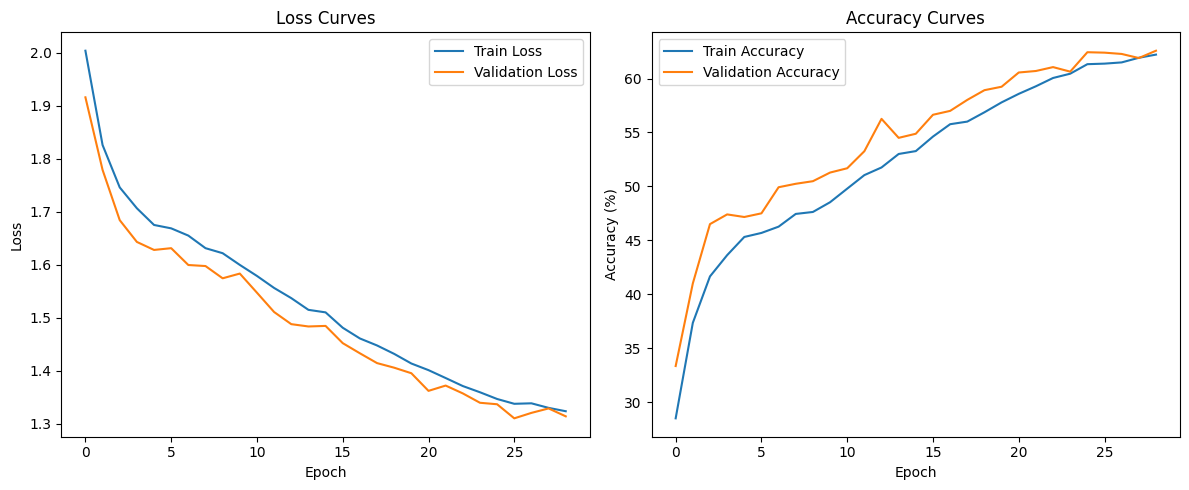

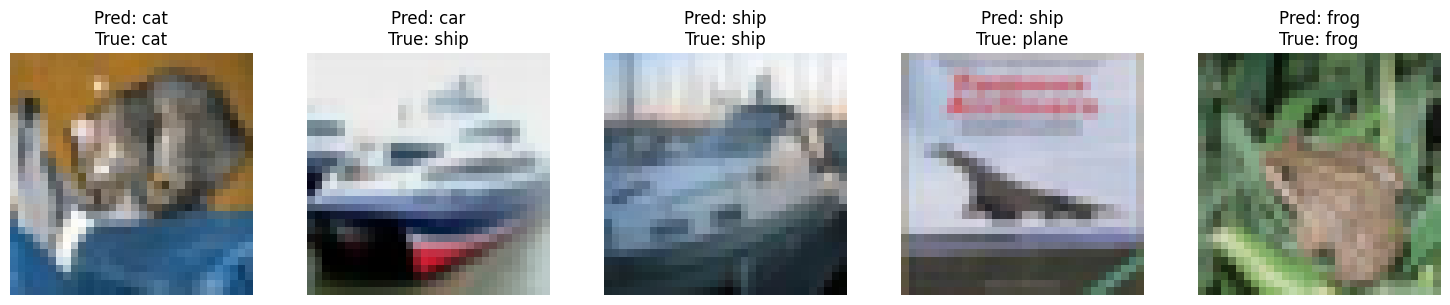

Running experiment with config: {'experiment_name': 'pos_sinusoidal', 'batch_size': 128, 'patch_size': 4, 'embedding_dim': 512, 'depth': 6, 'num_heads': 4, 'mlp_ratio': 2.0, 'dropout': 0.1, 'learning_rate': 0.0003, 'weight_decay': 0.0001, 'num_epochs': 30, 'patience': 3, 'augment': True, 'visualize_architecture': False, 'qkv_bias': True, 'use_faster_attention': True, 'pos_embedding_type': 'sinusoidal'}
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.93it/s, loss=1.75, acc=41.9]


Train Loss: 1.9586, Train Acc: 31.34%
Val Loss: 1.7533, Val Acc: 41.92%
Validation loss decreased (inf --> 1.753307). Saving model...

Epoch 2/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.27it/s, loss=1.67, acc=45.4]


Train Loss: 1.7565, Train Acc: 41.96%
Val Loss: 1.6661, Val Acc: 45.42%
Validation loss decreased (1.753307 --> 1.666103). Saving model...

Epoch 3/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.96it/s, loss=1.63, acc=46.9]


Train Loss: 1.7020, Train Acc: 44.25%
Val Loss: 1.6256, Val Acc: 46.86%
Validation loss decreased (1.666103 --> 1.625645). Saving model...

Epoch 4/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.09it/s, loss=1.67, acc=46.2]


Train Loss: 1.6708, Train Acc: 45.86%
Val Loss: 1.6704, Val Acc: 46.20%
EarlyStopping counter: 1 out of 3

Epoch 5/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.15it/s, loss=1.61, acc=47.6]


Train Loss: 1.6501, Train Acc: 46.82%
Val Loss: 1.6098, Val Acc: 47.60%
Validation loss decreased (1.625645 --> 1.609848). Saving model...

Epoch 6/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.49it/s, loss=1.61, acc=48.6]


Train Loss: 1.6384, Train Acc: 47.41%
Val Loss: 1.6132, Val Acc: 48.60%
EarlyStopping counter: 1 out of 3

Epoch 7/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.31it/s, loss=1.58, acc=50.3]


Train Loss: 1.6383, Train Acc: 47.14%
Val Loss: 1.5797, Val Acc: 50.28%
Validation loss decreased (1.609848 --> 1.579745). Saving model...

Epoch 8/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.34it/s, loss=1.61, acc=48.8]


Train Loss: 1.6300, Train Acc: 47.64%
Val Loss: 1.6064, Val Acc: 48.76%
EarlyStopping counter: 1 out of 3

Epoch 9/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.92it/s, loss=1.57, acc=49.7]


Train Loss: 1.6092, Train Acc: 48.51%
Val Loss: 1.5723, Val Acc: 49.66%
Validation loss decreased (1.579745 --> 1.572310). Saving model...

Epoch 10/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.29it/s, loss=1.56, acc=50.3]


Train Loss: 1.6082, Train Acc: 48.46%
Val Loss: 1.5583, Val Acc: 50.30%
Validation loss decreased (1.572310 --> 1.558327). Saving model...

Epoch 11/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.73it/s, loss=1.56, acc=50.7]


Train Loss: 1.5941, Train Acc: 49.18%
Val Loss: 1.5626, Val Acc: 50.66%
EarlyStopping counter: 1 out of 3

Epoch 12/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.37it/s, loss=1.56, acc=51.2]


Train Loss: 1.5843, Train Acc: 49.93%
Val Loss: 1.5615, Val Acc: 51.16%
EarlyStopping counter: 2 out of 3

Epoch 13/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.52it/s, loss=1.5, acc=52.6] 


Train Loss: 1.5683, Train Acc: 50.55%
Val Loss: 1.5020, Val Acc: 52.58%
Validation loss decreased (1.558327 --> 1.501980). Saving model...

Epoch 14/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.55it/s, loss=1.51, acc=52.3]


Train Loss: 1.5429, Train Acc: 51.57%
Val Loss: 1.5145, Val Acc: 52.32%
EarlyStopping counter: 1 out of 3

Epoch 15/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.49it/s, loss=1.51, acc=52.7]


Train Loss: 1.5395, Train Acc: 51.70%
Val Loss: 1.5126, Val Acc: 52.74%
EarlyStopping counter: 2 out of 3

Epoch 16/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.64it/s, loss=1.47, acc=55.5]


Train Loss: 1.5167, Train Acc: 53.05%
Val Loss: 1.4690, Val Acc: 55.50%
Validation loss decreased (1.501980 --> 1.469018). Saving model...

Epoch 17/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.24it/s, loss=1.44, acc=55.7]


Train Loss: 1.4952, Train Acc: 54.06%
Val Loss: 1.4401, Val Acc: 55.72%
Validation loss decreased (1.469018 --> 1.440097). Saving model...

Epoch 18/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.16it/s, loss=1.43, acc=57.2]


Train Loss: 1.4760, Train Acc: 55.22%
Val Loss: 1.4307, Val Acc: 57.22%
Validation loss decreased (1.440097 --> 1.430695). Saving model...

Epoch 19/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.54it/s, loss=1.41, acc=57.3]


Train Loss: 1.4560, Train Acc: 56.01%
Val Loss: 1.4057, Val Acc: 57.34%
Validation loss decreased (1.430695 --> 1.405656). Saving model...

Epoch 20/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.65it/s, loss=1.4, acc=57.9] 


Train Loss: 1.4451, Train Acc: 56.50%
Val Loss: 1.4039, Val Acc: 57.88%
Validation loss decreased (1.405656 --> 1.403926). Saving model...

Epoch 21/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.60it/s, loss=1.38, acc=58.7]


Train Loss: 1.4316, Train Acc: 57.02%
Val Loss: 1.3840, Val Acc: 58.72%
Validation loss decreased (1.403926 --> 1.384043). Saving model...

Epoch 22/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.70it/s, loss=1.38, acc=58.8]


Train Loss: 1.4132, Train Acc: 57.88%
Val Loss: 1.3755, Val Acc: 58.82%
Validation loss decreased (1.384043 --> 1.375466). Saving model...

Epoch 23/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.04it/s, loss=1.37, acc=59.7]


Train Loss: 1.4042, Train Acc: 58.28%
Val Loss: 1.3731, Val Acc: 59.66%
Validation loss decreased (1.375466 --> 1.373118). Saving model...

Epoch 24/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.69it/s, loss=1.36, acc=59.9]


Train Loss: 1.3889, Train Acc: 59.13%
Val Loss: 1.3636, Val Acc: 59.92%
Validation loss decreased (1.373118 --> 1.363649). Saving model...

Epoch 25/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.76it/s, loss=1.34, acc=61.5]


Train Loss: 1.3815, Train Acc: 59.48%
Val Loss: 1.3403, Val Acc: 61.48%
Validation loss decreased (1.363649 --> 1.340257). Saving model...

Epoch 26/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.70it/s, loss=1.34, acc=61.4]


Train Loss: 1.3695, Train Acc: 60.21%
Val Loss: 1.3444, Val Acc: 61.42%
EarlyStopping counter: 1 out of 3

Epoch 27/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.95it/s, loss=1.34, acc=60.9]


Train Loss: 1.3636, Train Acc: 60.08%
Val Loss: 1.3376, Val Acc: 60.90%
Validation loss decreased (1.340257 --> 1.337596). Saving model...

Epoch 28/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.20it/s, loss=1.33, acc=61.9]


Train Loss: 1.3599, Train Acc: 60.49%
Val Loss: 1.3300, Val Acc: 61.86%
Validation loss decreased (1.337596 --> 1.330049). Saving model...

Epoch 29/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.42it/s, loss=1.32, acc=61.7]


Train Loss: 1.3602, Train Acc: 60.41%
Val Loss: 1.3210, Val Acc: 61.72%
Validation loss decreased (1.330049 --> 1.321041). Saving model...

Epoch 30/30


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.39it/s, loss=1.33, acc=62]  


Train Loss: 1.3546, Train Acc: 60.68%
Val Loss: 1.3301, Val Acc: 62.00%
EarlyStopping counter: 1 out of 3


Testing: 100%|██████████| 79/79 [00:04<00:00, 18.66it/s]


Test Accuracy: 63.49%


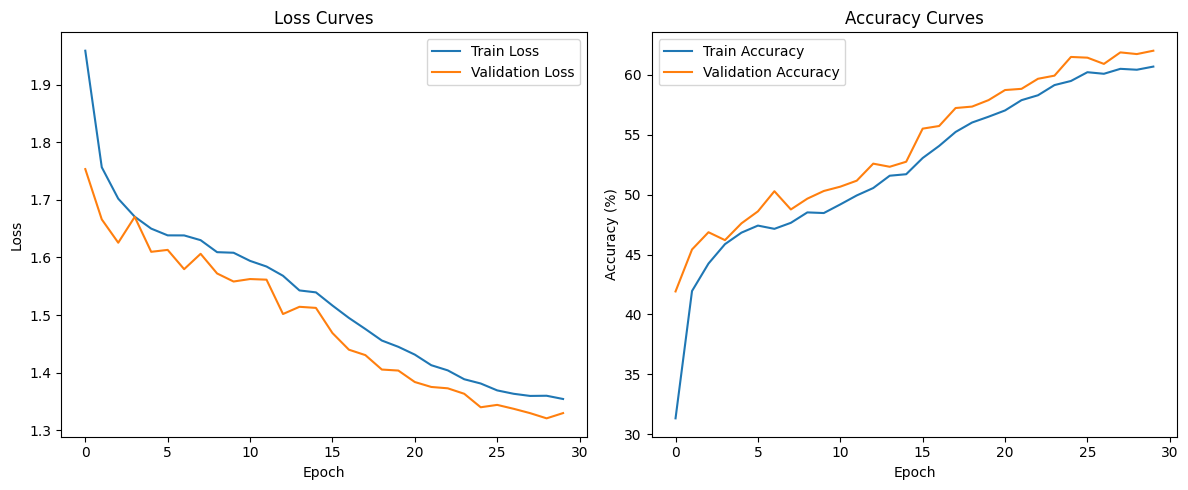

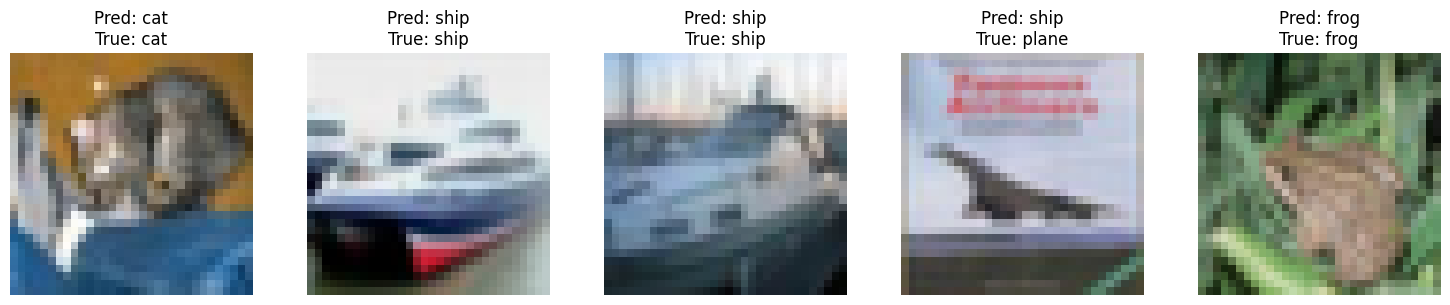


Positional Embedding Results:
Pos Embedding: 1d_learned, Test Accuracy: 65.45%
Pos Embedding: 2d_learned, Test Accuracy: 63.63%
Pos Embedding: sinusoidal, Test Accuracy: 63.49%


In [29]:
# Run positional embedding experiment
print("\n=== Running Positional Embedding Experiment ===")
pos_results = positional_embedding_experiment()

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import seaborn as sns
import math
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap for attention visualization (from blue to red)
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
attention_cmap = LinearSegmentedColormap.from_list('attention_cmap', colors, N=256)

def get_attention_maps(model, image_batch, layer_idx=None, head_idx=None):
    """
    Extract attention maps from the model for a given image batch.
    
    Args:
        model: DiffVisionTransformer model
        image_batch: Batch of images to process
        layer_idx: Index of the transformer layer to extract attention from (None for all layers)
        head_idx: Index of the attention head to extract (None for all heads)
        
    Returns:
        Dict containing attention maps for each layer and head
    """
    model.eval()
    B = image_batch.shape[0]
    attention_maps = {}
    
    # Register hooks to capture attention maps
    hooks = []
    
    def get_attention_hook(layer_name):
        def hook(module, input, output):
            # Extract attention weights from the differential attention module
            # For the DifferentialAttention class, we need to compute the attention weights
            q = module.q(input[0]).reshape(B, -1, module.num_heads, module.head_dim).permute(0, 2, 1, 3)
            k = module.k(input[0]).reshape(B, -1, module.num_heads, module.head_dim).permute(0, 2, 1, 3)
            k_prime = module.k_prime(input[0]).reshape(B, -1, module.num_heads, module.head_dim).permute(0, 2, 1, 3)
            
            # Compute attention scores
            attn_scores = (q @ k.transpose(-2, -1)) * module.scale
            attn_scores_prime = (q @ k_prime.transpose(-2, -1)) * module.scale
            diff_attn = attn_scores - attn_scores_prime
            
            # Apply softmax to get attention weights
            attn_weights = torch.nn.functional.softmax(diff_attn, dim=-1)
            
            attention_maps[layer_name] = attn_weights.detach()
        return hook
    
    # Register hooks for each transformer block
    for i, block in enumerate(model.transformer_blocks):
        if layer_idx is None or layer_idx == i:
            layer_name = f"layer_{i}"
            hook = block.diff_attn.register_forward_hook(get_attention_hook(layer_name))
            hooks.append(hook)
    
    # Forward pass with the image batch
    with torch.no_grad():
        _ = model(image_batch)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Process the attention maps based on head_idx
    result = {}
    for layer_name, attn in attention_maps.items():
        # attn shape: [B, num_heads, seq_len, seq_len]
        if head_idx is not None:
            result[layer_name] = attn[:, head_idx:head_idx+1]
        else:
            result[layer_name] = attn
    
    return result

def visualize_cls_token_attention(model, images, labels, class_names, device, save_path=None):
    """
    Visualize attention from the [CLS] token to patch tokens for each head and the average.
    
    Args:
        model: DiffVisionTransformer model
        images: Batch of images to visualize (already preprocessed)
        labels: Ground truth labels for the images
        class_names: Names of the classes
        device: Device to run the model on
        save_path: Path to save the visualization (optional)
    """
    model.eval()
    
    # Forward pass to get attention maps
    images = images.to(device)
    batch_size = images.shape[0]
    num_samples = min(batch_size, 4)  # Visualize up to 4 images
    
    # Get attention maps for the last layer
    attention_maps = get_attention_maps(model, images, layer_idx=len(model.transformer_blocks)-1)
    last_layer_attn = list(attention_maps.values())[0]  # [B, H, N, N]
    
    # Extract attention from [CLS] token (index 0) to all patch tokens
    cls_attention = last_layer_attn[:, :, 0, 1:]  # [B, H, num_patches]
    
    # Number of heads and patches
    batch_size, num_heads, num_patches = cls_attention.shape
    patch_size = model.patch_size
    grid_size = int(math.sqrt(num_patches))
    
    # Create a figure for visualization
    fig = plt.figure(figsize=(20, 5 * num_samples))
    
    for sample_idx in range(num_samples):
        # Original image
        ax = fig.add_subplot(num_samples, num_heads + 2, sample_idx * (num_heads + 2) + 1)
        img = images[sample_idx].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Original Image\nTrue: {class_names[labels[sample_idx]]}")
        ax.axis('off')
        
        # Average attention across all heads
        avg_attn = cls_attention[sample_idx].mean(0).reshape(grid_size, grid_size).cpu().numpy()
        ax = fig.add_subplot(num_samples, num_heads + 2, sample_idx * (num_heads + 2) + 2)
        sns.heatmap(avg_attn, ax=ax, cmap=attention_cmap, square=True, cbar=False)
        ax.set_title("Average Attention")
        ax.axis('off')
        
        # Attention for each head
        for head_idx in range(num_heads):
            attn = cls_attention[sample_idx, head_idx].reshape(grid_size, grid_size).cpu().numpy()
            ax = fig.add_subplot(num_samples, num_heads + 2, sample_idx * (num_heads + 2) + head_idx + 3)
            sns.heatmap(attn, ax=ax, cmap=attention_cmap, square=True, cbar=False)
            ax.set_title(f"Head {head_idx}")
            ax.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
    return fig

def visualize_cls_attention_across_layers(model, images, labels, class_names, device, save_path=None):
    """
    Visualize attention from [CLS] token to patch tokens across all layers.
    
    Args:
        model: DiffVisionTransformer model
        images: Batch of images to visualize
        labels: Ground truth labels for the images
        class_names: Names of the classes
        device: Device to run the model on
        save_path: Path to save the visualization (optional)
    """
    model.eval()
    
    # Forward pass to get attention maps
    images = images.to(device)
    batch_size = images.shape[0]
    num_samples = min(batch_size, 2)  # Visualize up to 2 images
    num_layers = len(model.transformer_blocks)
    
    # Get attention maps for all layers
    attention_maps = get_attention_maps(model, images)
    
    # Create a figure for visualization
    fig = plt.figure(figsize=(20, 3 * num_samples * num_layers))
    
    for sample_idx in range(num_samples):
        # Original image
        ax = fig.add_subplot(num_samples, num_layers + 1, sample_idx * (num_layers + 1) + 1)
        img = images[sample_idx].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Original Image\nTrue: {class_names[labels[sample_idx]]}")
        ax.axis('off')
        
        # Attention for each layer (averaged across heads)
        for layer_idx in range(num_layers):
            layer_name = f"layer_{layer_idx}"
            layer_attn = attention_maps[layer_name][sample_idx]  # [H, N, N]
            
            # Extract attention from [CLS] token (index 0) to all patch tokens
            cls_attention = layer_attn[:, 0, 1:]  # [H, num_patches]
            
            # Average across heads
            avg_attn = cls_attention.mean(0)  # [num_patches]
            
            # Reshape to grid
            grid_size = int(math.sqrt(avg_attn.shape[0]))
            avg_attn = avg_attn.reshape(grid_size, grid_size).cpu().numpy()
            
            # Plot
            ax = fig.add_subplot(num_samples, num_layers + 1, sample_idx * (num_layers + 1) + layer_idx + 2)
            sns.heatmap(avg_attn, ax=ax, cmap=attention_cmap, square=True, cbar=False)
            ax.set_title(f"Layer {layer_idx}")
            ax.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
    return fig

def attention_rollout(attn_matrices, head_fusion="mean", discard_ratio=0.9):
    """
    Compute attention rollout as in https://arxiv.org/abs/2005.00928
    
    Args:
        attn_matrices: List of attention matrices from each layer
        head_fusion: How to combine attention heads - 'mean' or 'max'
        discard_ratio: Ratio of attention scores to discard (keep only top scores)
        
    Returns:
        Attention rollout matrix
    """
    # attn_matrices shape: list of [batch_size, num_heads, seq_len, seq_len]
    batch_size = attn_matrices[0].shape[0]
    num_tokens = attn_matrices[0].shape[2]
    
    # Initialize identity matrix as the first rollout step
    eye = torch.eye(num_tokens).unsqueeze(0).repeat(batch_size, 1, 1).to(attn_matrices[0].device)
    rollout = eye
    
    # Compute rollout through layers
    for attn in attn_matrices:
        # Fuse heads
        if head_fusion == "mean":
            attn_fused = attn.mean(dim=1)
        elif head_fusion == "max":
            attn_fused = attn.max(dim=1)[0]
        elif head_fusion == "min":
            attn_fused = attn.min(dim=1)[0]
        else:
            raise ValueError(f"Invalid head_fusion: {head_fusion}")
        
        # Apply discard_ratio
        if discard_ratio > 0:
            # Flatten to apply quantile
            flat = attn_fused.reshape(batch_size, -1)
            
            # Calculate threshold value
            k = int((1 - discard_ratio) * flat.shape[1])
            
            # Get top-k threshold for each sample
            vals, _ = torch.topk(flat, k, dim=1)
            threshold = vals[:, -1].unsqueeze(1).unsqueeze(2)
            
            # Apply threshold
            mask = attn_fused >= threshold
            attn_fused = attn_fused * mask.float()
            
            # Re-normalize
            attn_fused = attn_fused / (attn_fused.sum(dim=-1, keepdim=True) + 1e-8)
        
        # Update rollout
        rollout = torch.bmm(attn_fused, rollout)
    
    return rollout

def visualize_attention_rollout(model, images, labels, class_names, device, save_path=None,
                               head_fusion="mean", discard_ratio=0.9):
    """
    Visualize attention rollout for a batch of images.
    
    Args:
        model: DiffVisionTransformer model
        images: Batch of images to visualize
        labels: Ground truth labels for the images
        class_names: Names of the classes
        device: Device to run the model on
        save_path: Path to save the visualization (optional)
        head_fusion: How to combine attention heads - 'mean' or 'max'
        discard_ratio: Ratio of attention scores to discard (keep only top scores)
    """
    model.eval()
    
    # Get attention maps for all layers
    images = images.to(device)
    batch_size = images.shape[0]
    num_samples = min(batch_size, 4)  # Visualize up to 4 images
    
    attention_maps = get_attention_maps(model, images)
    num_layers = len(attention_maps)
    
    # Extract attention matrices from each layer
    attn_matrices = [attention_maps[f"layer_{i}"] for i in range(num_layers)]
    
    # Compute attention rollout
    rollout = attention_rollout(attn_matrices, head_fusion, discard_ratio)
    
    # Extract attention from [CLS] token to patch tokens
    cls_rollout = rollout[:, 0, 1:]  # [B, num_patches]
    
    # Reshape to grids
    patch_size = model.patch_size
    grid_size = int(math.sqrt(cls_rollout.shape[1]))
    
    # Visualize
    fig = plt.figure(figsize=(15, 5 * num_samples))
    
    for sample_idx in range(num_samples):
        # Original image
        ax = fig.add_subplot(num_samples, 3, sample_idx * 3 + 1)
        img = images[sample_idx].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Original Image\nTrue: {class_names[labels[sample_idx]]}")
        ax.axis('off')
        
        # Attention rollout as heatmap
        rollout_grid = cls_rollout[sample_idx].reshape(grid_size, grid_size).cpu().numpy()
        ax = fig.add_subplot(num_samples, 3, sample_idx * 3 + 2)
        sns.heatmap(rollout_grid, ax=ax, cmap=attention_cmap, square=True, cbar=False)
        ax.set_title("Attention Rollout")
        ax.axis('off')
        
        # Overlay attention on image
        ax = fig.add_subplot(num_samples, 3, sample_idx * 3 + 3)
        
        # Upscale rollout to match image size
        h, w = img.shape[:2]
        rollout_upscaled = torch.nn.functional.interpolate(
            cls_rollout[sample_idx].reshape(1, 1, grid_size, grid_size),
            size=(h, w),
            mode='bilinear'
        )[0, 0].cpu().numpy()
        
        # Normalize rollout for visualization
        rollout_upscaled = (rollout_upscaled - rollout_upscaled.min()) / (rollout_upscaled.max() - rollout_upscaled.min() + 1e-10)
        
        # Create a blended image
        cmap = plt.get_cmap('jet')
        rollout_colored = cmap(rollout_upscaled)[:, :, :3]
        
        # Blend original image with rollout
        alpha = 0.6
        blended = (1 - alpha) * img + alpha * rollout_colored
        
        ax.imshow(blended)
        ax.set_title("Attention Overlay")
        ax.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
    return fig

# Main function to run attention visualization
def run_attention_visualization(model,config):
    """
    Run attention visualization for a trained model.
    
    Args:
      
        config: Model configuration dictionary
    """
    # Create dataloaders
    _, val_loader, test_loader = get_dataloaders(
        batch_size=16,  # Smaller batch size for visualization
        patch_size=config['patch_size'],
        augment=False  # No augmentation for test images
    )
    model.to(device)
   
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Define class names
    class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    # 1. Visualize attention from [CLS] token to patch tokens for the last layer
    print("Visualizing attention from [CLS] token to patch tokens for the last layer...")
    visualize_cls_token_attention(
        model, images, labels, class_names, device,
        save_path="cls_token_attention_last_layer.png"
    )
    
    # 2. Visualize attention from [CLS] token to patch tokens across all layers
    print("Visualizing attention from [CLS] token to patch tokens across all layers...")
    visualize_cls_attention_across_layers(
        model, images, labels, class_names, device,
        save_path="cls_token_attention_all_layers.png"
    )
    
    # 3. Visualize attention rollout
    print("Visualizing attention rollout...")
    visualize_attention_rollout(
        model, images, labels, class_names, device,
        save_path="attention_rollout.png",
        head_fusion="mean",
        discard_ratio=0.9
    )
    
    print("All visualizations completed!")


Running experiment with config: {'experiment_name': 'vit_tuned', 'batch_size': 128, 'patch_size': 4, 'embedding_dim': 256, 'depth': 8, 'num_heads': 8, 'mlp_ratio': 2.0, 'dropout': 0.1, 'learning_rate': 0.0003, 'weight_decay': 0.05, 'num_epochs': 50, 'patience': 3, 'augment': True, 'pos_embedding_type': '1d_learned'}


100%|██████████| 170M/170M [00:16<00:00, 10.1MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Epoch 1/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.55it/s, loss=1.8, acc=38.7] 


Train Loss: 1.9371, Train Acc: 31.18%
Val Loss: 1.7998, Val Acc: 38.72%
Validation loss decreased (inf --> 1.799775). Saving model...

Epoch 2/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.48it/s, loss=1.62, acc=46.5]


Train Loss: 1.7041, Train Acc: 43.74%
Val Loss: 1.6234, Val Acc: 46.54%
Validation loss decreased (1.799775 --> 1.623445). Saving model...

Epoch 3/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.42it/s, loss=1.52, acc=51.3]


Train Loss: 1.5854, Train Acc: 49.54%
Val Loss: 1.5237, Val Acc: 51.28%
Validation loss decreased (1.623445 --> 1.523693). Saving model...

Epoch 4/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.41it/s, loss=1.44, acc=56.6]


Train Loss: 1.5123, Train Acc: 53.02%
Val Loss: 1.4374, Val Acc: 56.64%
Validation loss decreased (1.523693 --> 1.437397). Saving model...

Epoch 5/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.90it/s, loss=1.43, acc=57]  


Train Loss: 1.4610, Train Acc: 55.77%
Val Loss: 1.4291, Val Acc: 56.96%
Validation loss decreased (1.437397 --> 1.429100). Saving model...

Epoch 6/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.75it/s, loss=1.39, acc=58.4]


Train Loss: 1.4239, Train Acc: 57.42%
Val Loss: 1.3865, Val Acc: 58.42%
Validation loss decreased (1.429100 --> 1.386550). Saving model...

Epoch 7/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.76it/s, loss=1.36, acc=61.1]


Train Loss: 1.3909, Train Acc: 59.19%
Val Loss: 1.3568, Val Acc: 61.08%
Validation loss decreased (1.386550 --> 1.356799). Saving model...

Epoch 8/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s, loss=1.32, acc=62.2]


Train Loss: 1.3557, Train Acc: 60.84%
Val Loss: 1.3236, Val Acc: 62.16%
Validation loss decreased (1.356799 --> 1.323611). Saving model...

Epoch 9/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s, loss=1.31, acc=62.3]


Train Loss: 1.3311, Train Acc: 61.71%
Val Loss: 1.3148, Val Acc: 62.30%
Validation loss decreased (1.323611 --> 1.314774). Saving model...

Epoch 10/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.14it/s, loss=1.27, acc=65.1]


Train Loss: 1.3094, Train Acc: 63.12%
Val Loss: 1.2654, Val Acc: 65.14%
Validation loss decreased (1.314774 --> 1.265440). Saving model...

Epoch 11/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.50it/s, loss=1.25, acc=65.2]


Train Loss: 1.2897, Train Acc: 63.94%
Val Loss: 1.2475, Val Acc: 65.20%
Validation loss decreased (1.265440 --> 1.247529). Saving model...

Epoch 12/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.61it/s, loss=1.23, acc=66]  


Train Loss: 1.2644, Train Acc: 65.24%
Val Loss: 1.2286, Val Acc: 66.00%
Validation loss decreased (1.247529 --> 1.228555). Saving model...

Epoch 13/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.39it/s, loss=1.19, acc=68.5]


Train Loss: 1.2407, Train Acc: 66.15%
Val Loss: 1.1891, Val Acc: 68.48%
Validation loss decreased (1.228555 --> 1.189131). Saving model...

Epoch 14/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.56it/s, loss=1.2, acc=67.9] 


Train Loss: 1.2183, Train Acc: 67.05%
Val Loss: 1.1968, Val Acc: 67.86%
EarlyStopping counter: 1 out of 3

Epoch 15/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.67it/s, loss=1.16, acc=69.7]


Train Loss: 1.1984, Train Acc: 68.26%
Val Loss: 1.1597, Val Acc: 69.72%
Validation loss decreased (1.189131 --> 1.159744). Saving model...

Epoch 16/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.78it/s, loss=1.15, acc=70.2]


Train Loss: 1.1729, Train Acc: 69.20%
Val Loss: 1.1549, Val Acc: 70.20%
Validation loss decreased (1.159744 --> 1.154944). Saving model...

Epoch 17/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.66it/s, loss=1.14, acc=71.1]


Train Loss: 1.1540, Train Acc: 70.30%
Val Loss: 1.1401, Val Acc: 71.12%
Validation loss decreased (1.154944 --> 1.140059). Saving model...

Epoch 18/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.01it/s, loss=1.14, acc=70.8]


Train Loss: 1.1353, Train Acc: 70.97%
Val Loss: 1.1391, Val Acc: 70.78%
Validation loss decreased (1.140059 --> 1.139081). Saving model...

Epoch 19/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.84it/s, loss=1.1, acc=72.3] 


Train Loss: 1.1210, Train Acc: 71.83%
Val Loss: 1.1038, Val Acc: 72.26%
Validation loss decreased (1.139081 --> 1.103790). Saving model...

Epoch 20/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.83it/s, loss=1.09, acc=73]  


Train Loss: 1.1039, Train Acc: 72.56%
Val Loss: 1.0916, Val Acc: 72.96%
Validation loss decreased (1.103790 --> 1.091556). Saving model...

Epoch 21/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.31it/s, loss=1.09, acc=72.8]


Train Loss: 1.0853, Train Acc: 73.45%
Val Loss: 1.0935, Val Acc: 72.84%
EarlyStopping counter: 1 out of 3

Epoch 22/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.27it/s, loss=1.08, acc=74.1]


Train Loss: 1.0648, Train Acc: 74.45%
Val Loss: 1.0755, Val Acc: 74.10%
Validation loss decreased (1.091556 --> 1.075451). Saving model...

Epoch 23/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.68it/s, loss=1.06, acc=74.5]


Train Loss: 1.0489, Train Acc: 75.10%
Val Loss: 1.0555, Val Acc: 74.50%
Validation loss decreased (1.075451 --> 1.055495). Saving model...

Epoch 24/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.60it/s, loss=1.04, acc=74.8]


Train Loss: 1.0311, Train Acc: 75.78%
Val Loss: 1.0401, Val Acc: 74.84%
Validation loss decreased (1.055495 --> 1.040095). Saving model...

Epoch 25/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.44it/s, loss=1.06, acc=74.6]


Train Loss: 1.0161, Train Acc: 76.59%
Val Loss: 1.0600, Val Acc: 74.60%
EarlyStopping counter: 1 out of 3

Epoch 26/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.04it/s, loss=1.05, acc=75.7]


Train Loss: 0.9993, Train Acc: 77.55%
Val Loss: 1.0477, Val Acc: 75.68%
EarlyStopping counter: 2 out of 3

Epoch 27/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 20.36it/s, loss=1.04, acc=75.6]


Train Loss: 0.9859, Train Acc: 77.99%
Val Loss: 1.0358, Val Acc: 75.60%
Validation loss decreased (1.040095 --> 1.035843). Saving model...

Epoch 28/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.87it/s, loss=1.01, acc=77.1] 


Train Loss: 0.9739, Train Acc: 78.62%
Val Loss: 1.0084, Val Acc: 77.08%
Validation loss decreased (1.035843 --> 1.008371). Saving model...

Epoch 29/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.10it/s, loss=1.02, acc=76.8]


Train Loss: 0.9568, Train Acc: 79.44%
Val Loss: 1.0201, Val Acc: 76.82%
EarlyStopping counter: 1 out of 3

Epoch 30/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s, loss=0.995, acc=77.3]


Train Loss: 0.9426, Train Acc: 79.96%
Val Loss: 0.9955, Val Acc: 77.34%
Validation loss decreased (1.008371 --> 0.995451). Saving model...

Epoch 31/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.70it/s, loss=1, acc=77.9]    


Train Loss: 0.9234, Train Acc: 80.92%
Val Loss: 1.0011, Val Acc: 77.88%
EarlyStopping counter: 1 out of 3

Epoch 32/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.21it/s, loss=1.01, acc=77.9] 


Train Loss: 0.9194, Train Acc: 81.07%
Val Loss: 1.0111, Val Acc: 77.92%
EarlyStopping counter: 2 out of 3

Epoch 33/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 20.30it/s, loss=0.984, acc=78.5]


Train Loss: 0.9038, Train Acc: 81.96%
Val Loss: 0.9835, Val Acc: 78.52%
Validation loss decreased (0.995451 --> 0.983545). Saving model...

Epoch 34/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.68it/s, loss=0.981, acc=79.2]


Train Loss: 0.8903, Train Acc: 82.30%
Val Loss: 0.9813, Val Acc: 79.20%
Validation loss decreased (0.983545 --> 0.981274). Saving model...

Epoch 35/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.29it/s, loss=0.976, acc=79]  


Train Loss: 0.8782, Train Acc: 82.90%
Val Loss: 0.9760, Val Acc: 79.00%
Validation loss decreased (0.981274 --> 0.975990). Saving model...

Epoch 36/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 20.14it/s, loss=0.986, acc=78.8]


Train Loss: 0.8677, Train Acc: 83.61%
Val Loss: 0.9856, Val Acc: 78.76%
EarlyStopping counter: 1 out of 3

Epoch 37/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.75it/s, loss=0.967, acc=79.2]


Train Loss: 0.8613, Train Acc: 83.80%
Val Loss: 0.9668, Val Acc: 79.22%
Validation loss decreased (0.975990 --> 0.966813). Saving model...

Epoch 38/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.45it/s, loss=0.972, acc=79.3]


Train Loss: 0.8516, Train Acc: 84.30%
Val Loss: 0.9722, Val Acc: 79.28%
EarlyStopping counter: 1 out of 3

Epoch 39/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s, loss=0.958, acc=79]  


Train Loss: 0.8404, Train Acc: 84.79%
Val Loss: 0.9583, Val Acc: 78.98%
Validation loss decreased (0.966813 --> 0.958259). Saving model...

Epoch 40/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.39it/s, loss=0.957, acc=79.6]


Train Loss: 0.8329, Train Acc: 85.10%
Val Loss: 0.9568, Val Acc: 79.64%
Validation loss decreased (0.958259 --> 0.956758). Saving model...

Epoch 41/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.76it/s, loss=0.955, acc=80.1]


Train Loss: 0.8256, Train Acc: 85.41%
Val Loss: 0.9554, Val Acc: 80.08%
Validation loss decreased (0.956758 --> 0.955448). Saving model...

Epoch 42/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.40it/s, loss=0.962, acc=79.9]


Train Loss: 0.8193, Train Acc: 85.88%
Val Loss: 0.9618, Val Acc: 79.86%
EarlyStopping counter: 1 out of 3

Epoch 43/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s, loss=0.952, acc=80.6]


Train Loss: 0.8143, Train Acc: 86.07%
Val Loss: 0.9524, Val Acc: 80.64%
Validation loss decreased (0.955448 --> 0.952413). Saving model...

Epoch 44/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.95it/s, loss=0.951, acc=80.5]


Train Loss: 0.8067, Train Acc: 86.37%
Val Loss: 0.9508, Val Acc: 80.52%
Validation loss decreased (0.952413 --> 0.950827). Saving model...

Epoch 45/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.80it/s, loss=0.949, acc=80.4]


Train Loss: 0.8029, Train Acc: 86.61%
Val Loss: 0.9493, Val Acc: 80.38%
Validation loss decreased (0.950827 --> 0.949339). Saving model...

Epoch 46/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.97it/s, loss=0.944, acc=80.5]


Train Loss: 0.8036, Train Acc: 86.50%
Val Loss: 0.9444, Val Acc: 80.50%
Validation loss decreased (0.949339 --> 0.944394). Saving model...

Epoch 47/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.36it/s, loss=0.965, acc=80.4]


Train Loss: 0.7960, Train Acc: 86.86%
Val Loss: 0.9648, Val Acc: 80.40%
EarlyStopping counter: 1 out of 3

Epoch 48/50


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.70it/s, loss=0.962, acc=81]  


Train Loss: 0.7992, Train Acc: 86.74%
Val Loss: 0.9616, Val Acc: 80.98%
EarlyStopping counter: 2 out of 3

Epoch 49/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 20.60it/s, loss=0.964, acc=79.9]
/tmp/ipykernel_31/2527600923.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.loa

Train Loss: 0.7952, Train Acc: 86.80%
Val Loss: 0.9641, Val Acc: 79.94%
EarlyStopping counter: 3 out of 3
Early stopping triggered


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.99it/s]


Test Accuracy: 81.60%


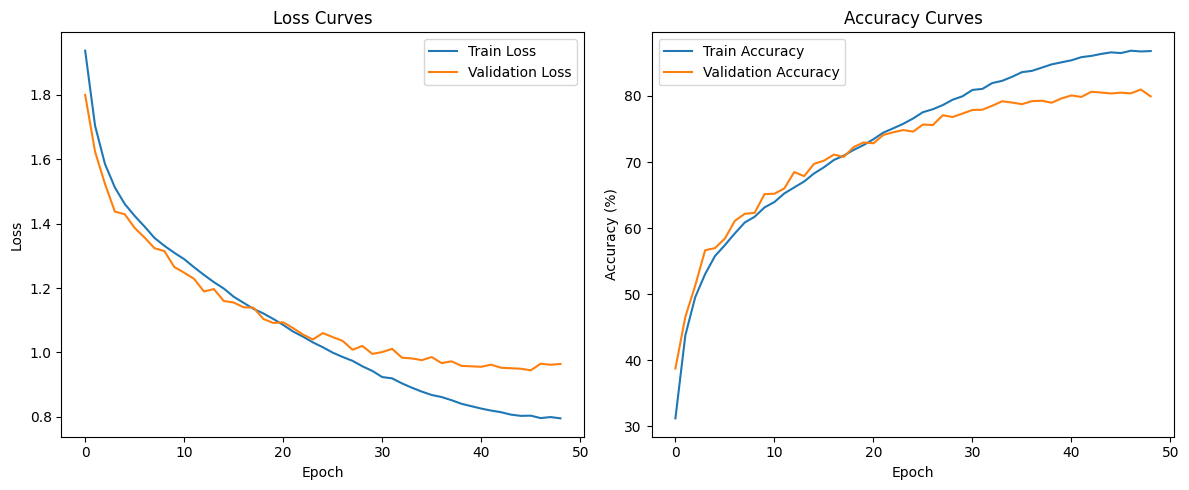

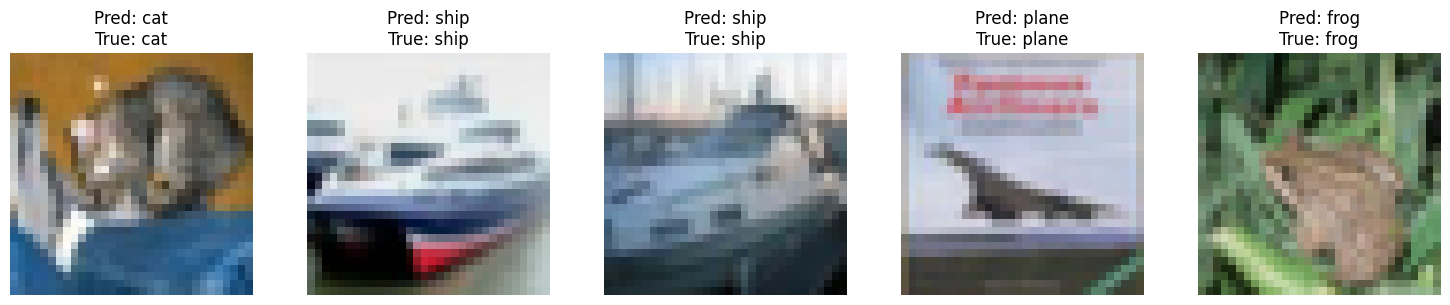

In [45]:
base_config = {
    'experiment_name': 'vit_tuned',
    'batch_size': 128,
    'patch_size': 4,
    'embedding_dim': 256,
    'depth': 8,
    'num_heads': 8,
    'mlp_ratio': 2.0,
    'dropout': 0.1,
    'learning_rate': 3e-4,
    'weight_decay': 0.05,
    'num_epochs': 50,
    'patience': 3,
    'augment': True,
    'pos_embedding_type': '1d_learned'}
    
    # Run base model with visualization
model, history, test_acc = run_experiment(base_config)



Files already downloaded and verified
Files already downloaded and verified
Visualizing attention from [CLS] token to patch tokens for the last layer...


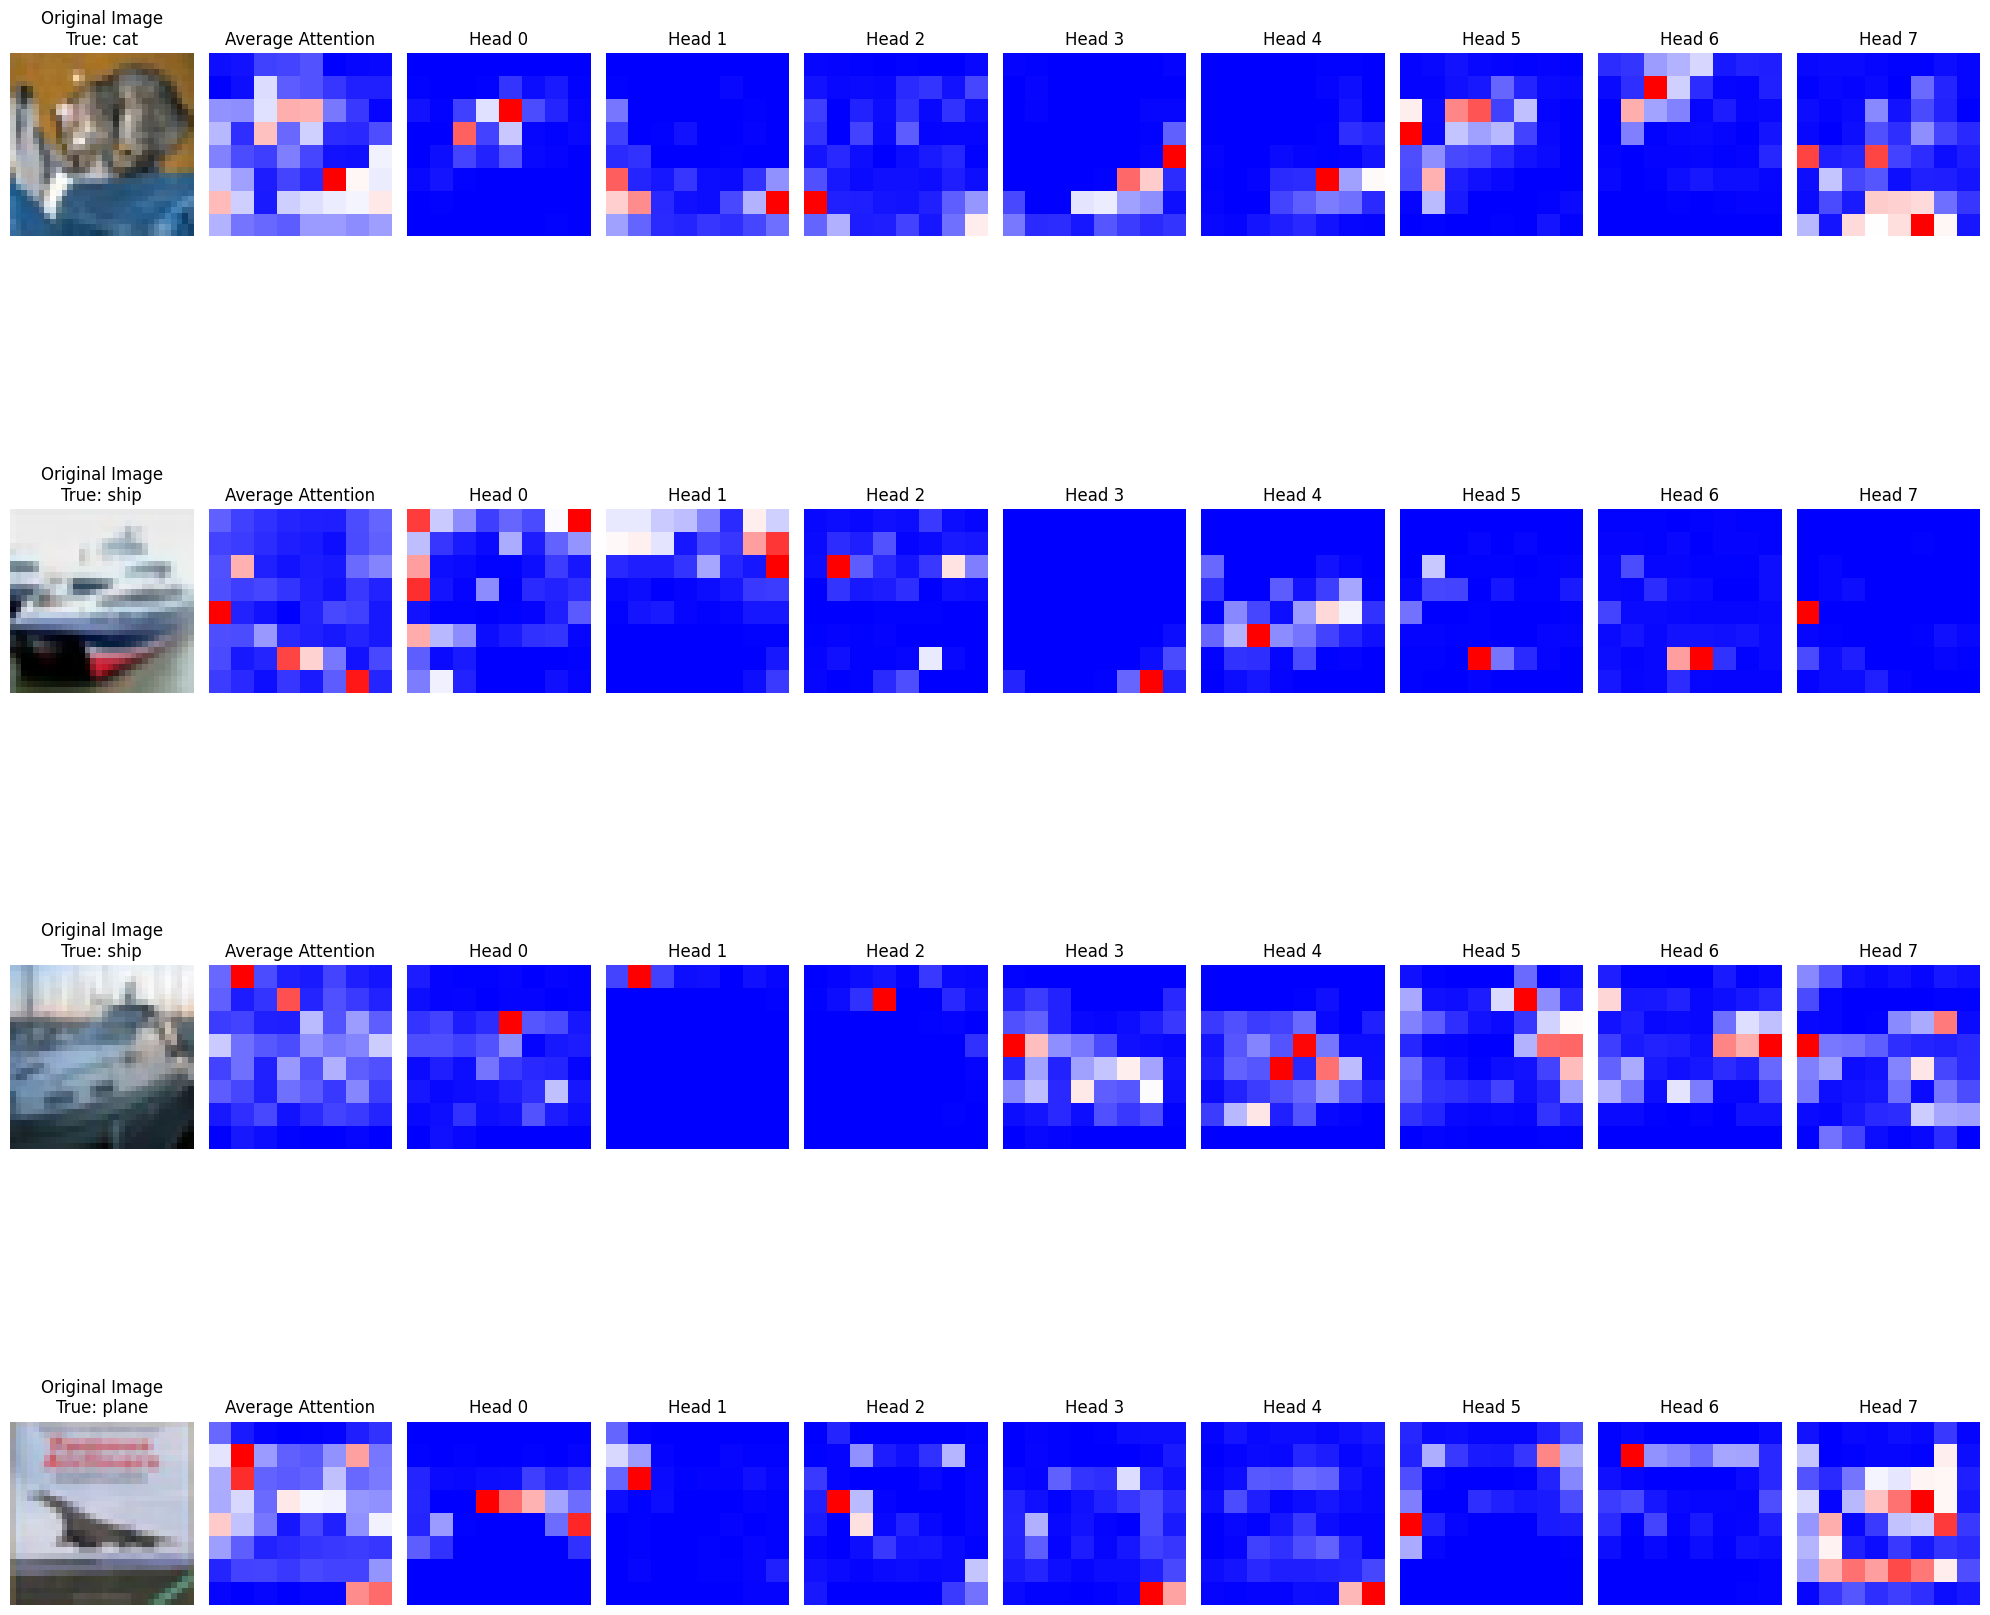

Visualizing attention from [CLS] token to patch tokens across all layers...


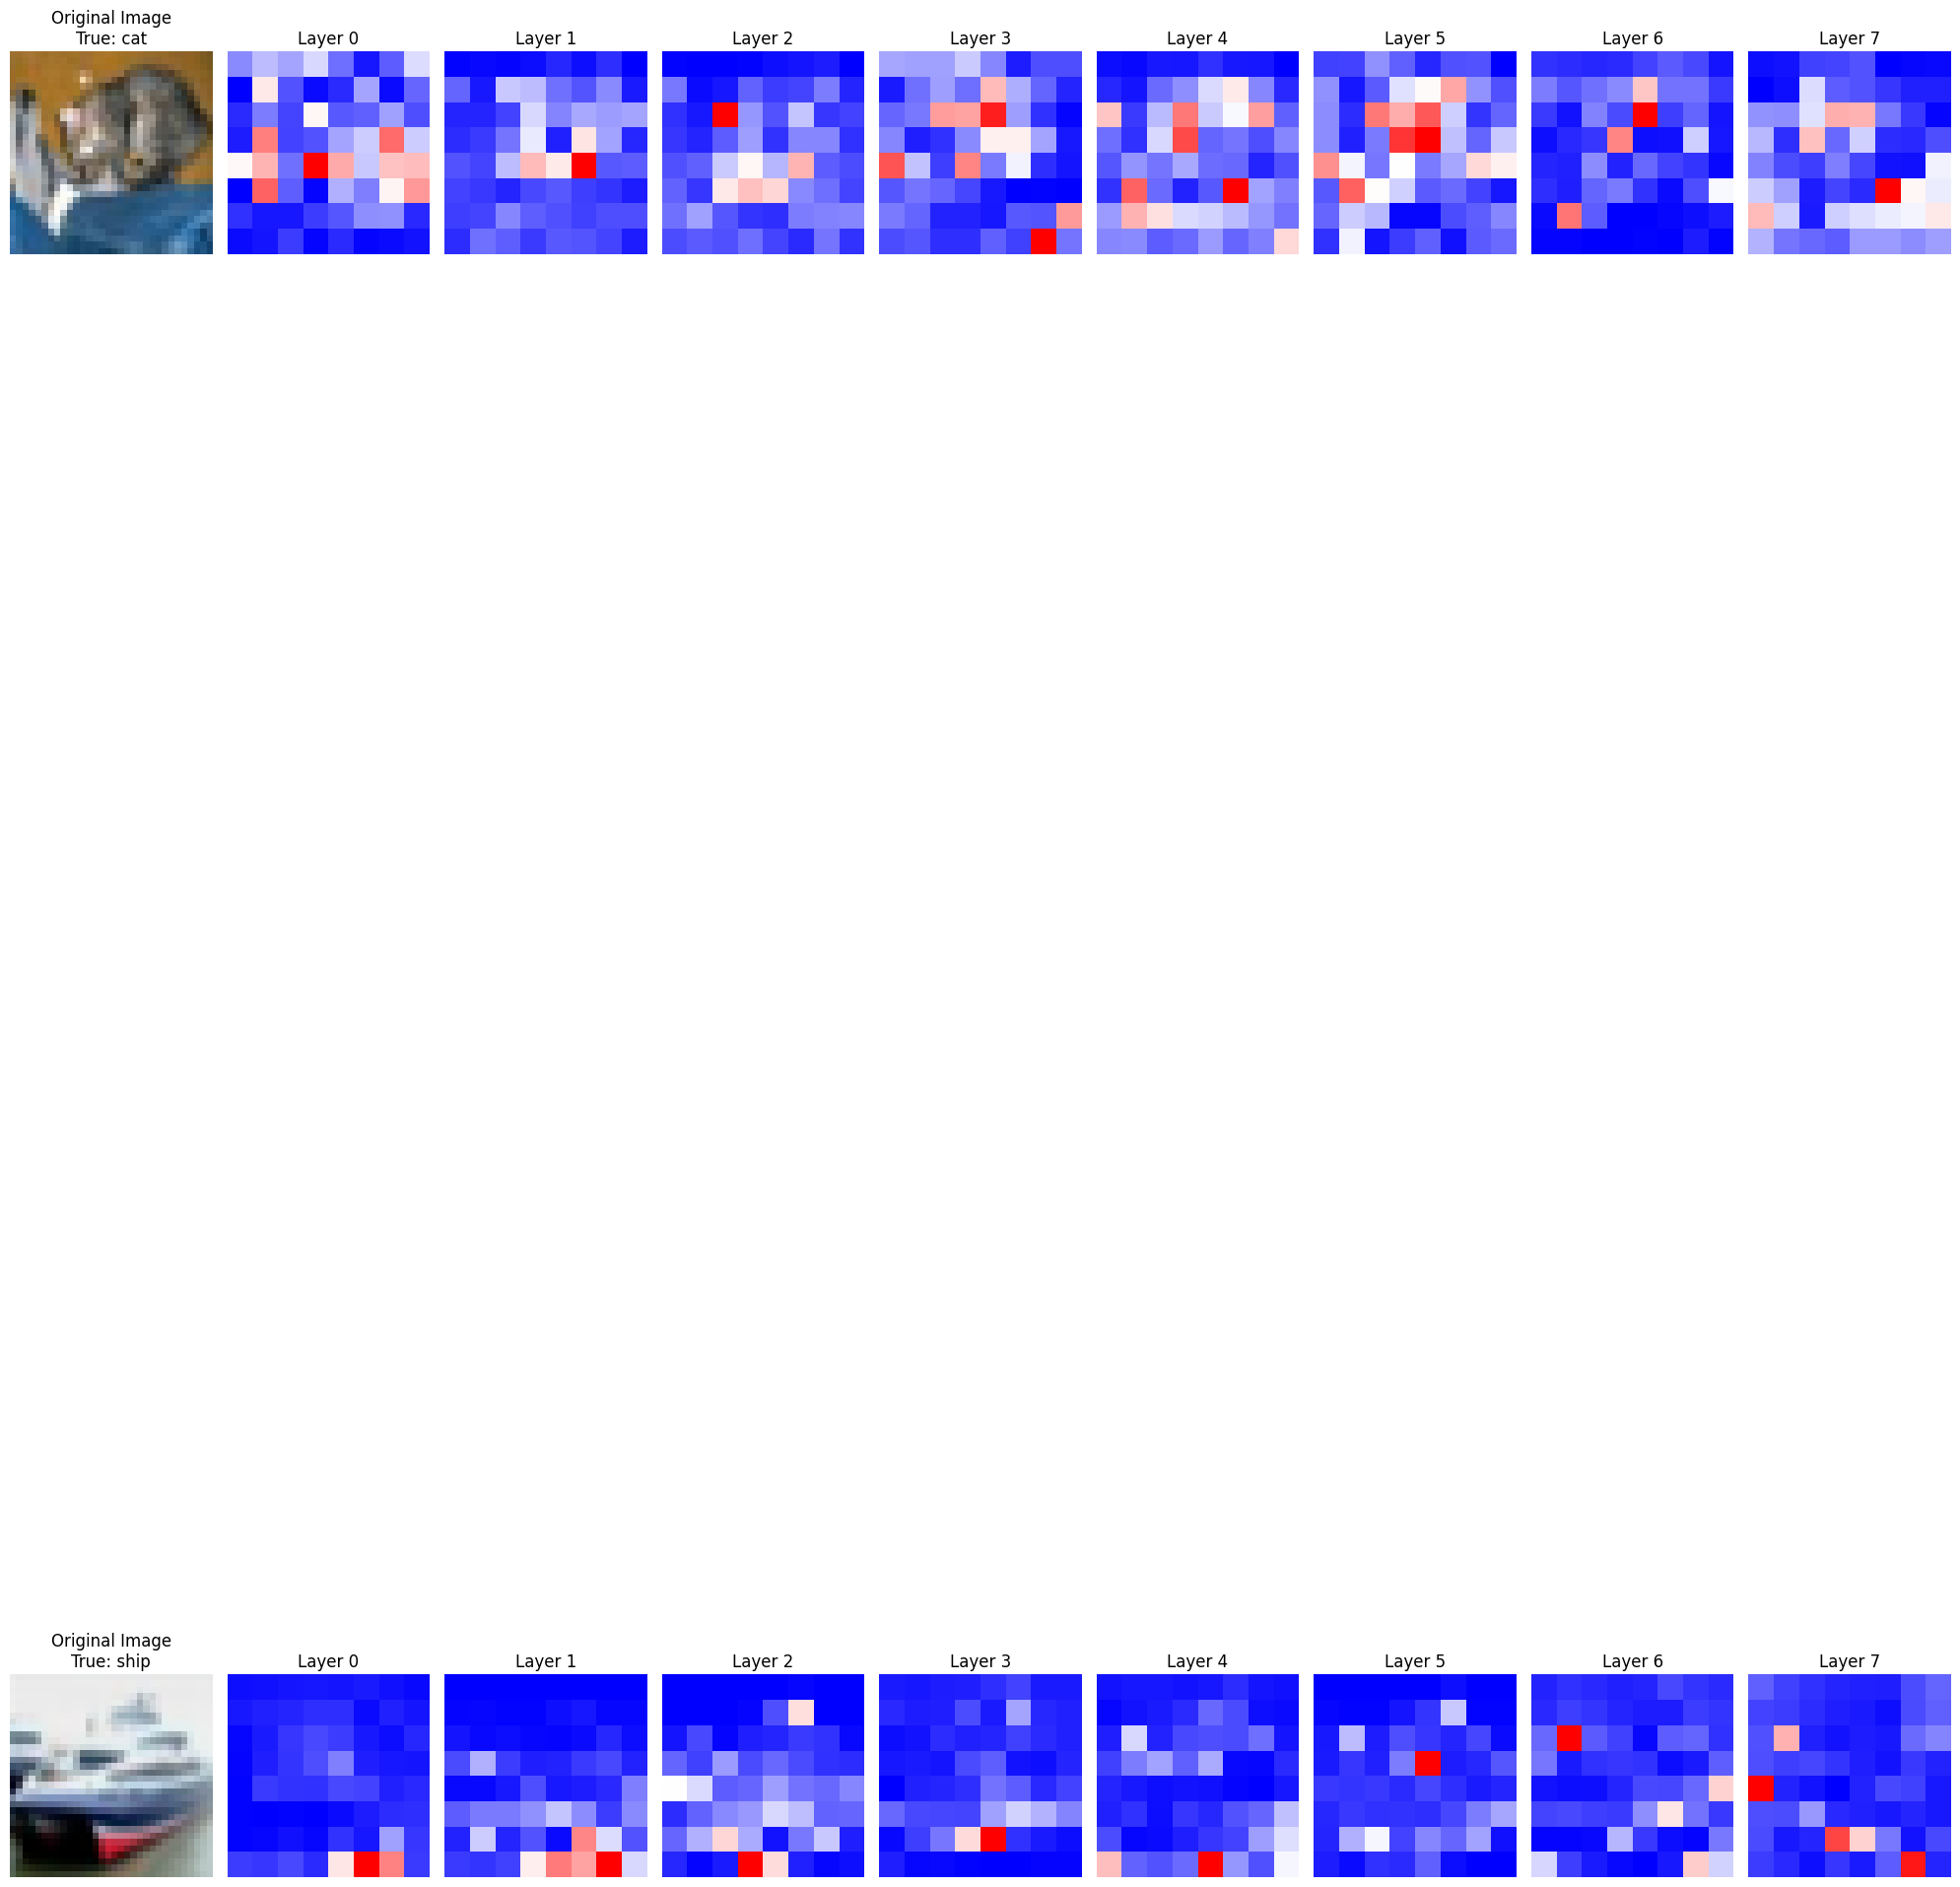

Visualizing attention rollout...


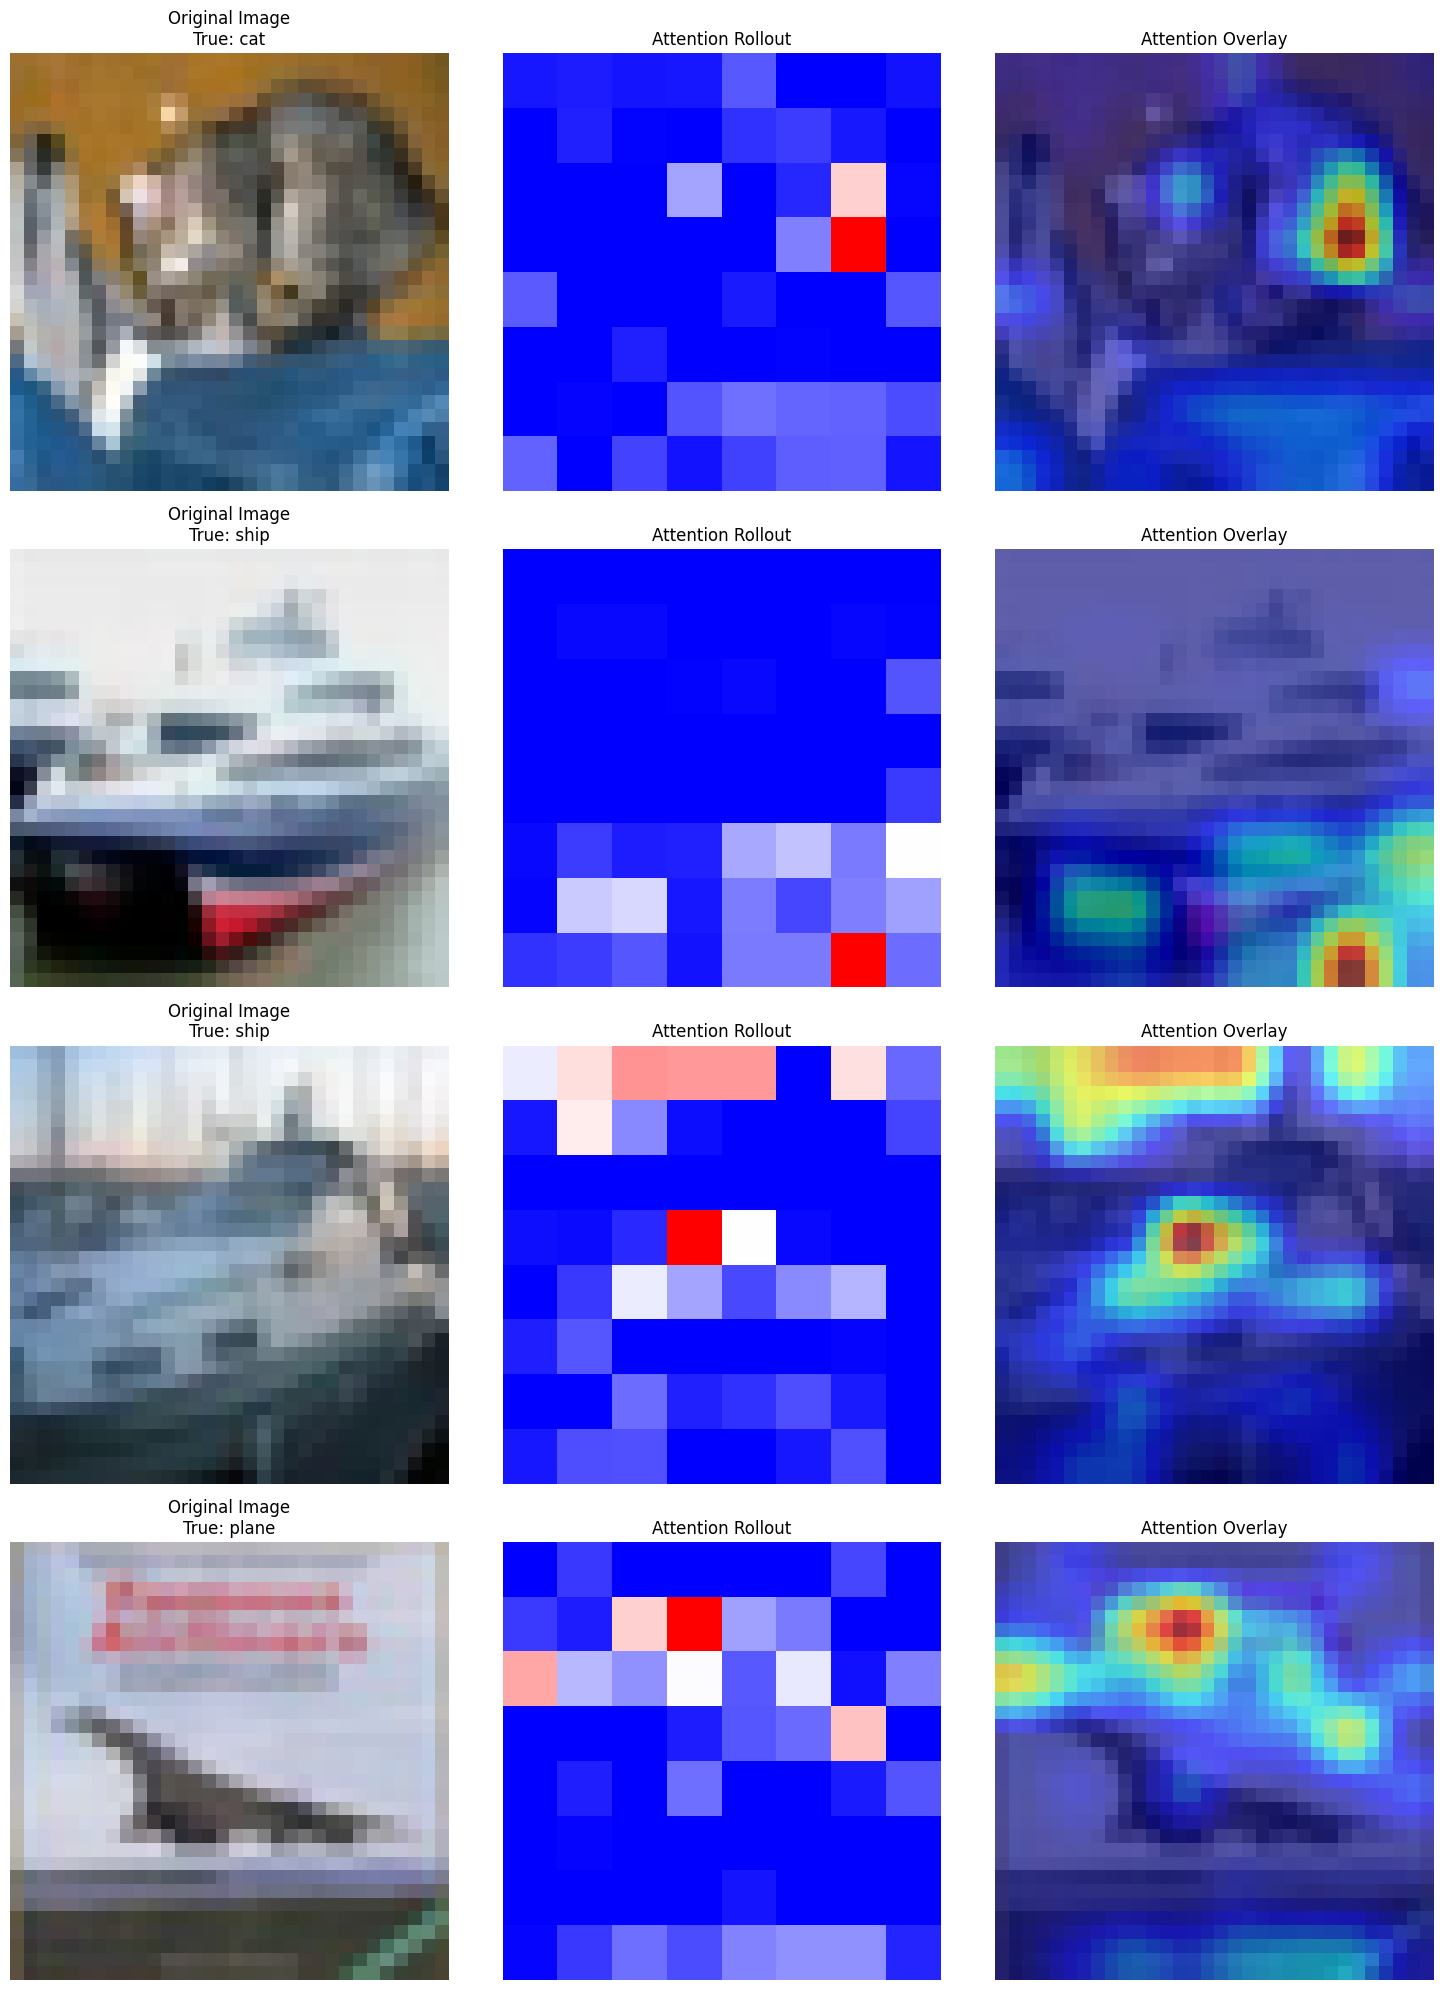

All visualizations completed!


In [52]:
run_attention_visualization(model, base_config)